# Suicide Detection - Modeling

### Table of Contents
* [Step 1. Imports](#Step-1:--Imports) 
* [Step 2. Load the Data](#Step-2:--Load-the-Data)
* [Step 3.  Look at Correlations](#Step-3:-Look-at-correlations)
* [Step 4.  Modeling](#Step-4:-Modeling)
    * [Step 4a)  Naive Bayes with Count Vectorizer - Text Only](#Step-4a:-Naive-Bayes-with-Count-Vectorizer---Text-Only)
    * [Step 4b)  Naive Bayes with Count Vectorizer - All Features](#Step-4b:-Naive-Bayes-with-Count-Vectorizer---All-Features)
    * [Step 4c)  Naive Bayes with TF-IDF - Text Only](#Step-4c:-Nave-Bayes-with-TF-IDF---Text-Only)
    * [Step 4d)  Naive Bayes with TF-IDF - All Features](#Step-4d:--Naive-Bayes---TF-IDF---All-Features)
    * [Step 4e)  Random Forest with Count Vectorizer - Text Only](#Step-4e:--Random-Forest-with-Count-Vectorizor---Text-Only)
    * [Step 4f)  Random Forest with Count Vectorizer - All Features](#Step-4f:--Random-Forest-with-Count-Vectorizer---All-Features)
    * [Step 4g)  Random Forest with TF-IDF - Text Only](#Step-4g:--Random-Forest-with-TF-IDF---Text-Only)
    * [Step 4h)  Random Forest with TF-IDF - All Features](#Step-4h:--Random-Forest-with-TF-IDF---All-Features)
    * [Step 4i)  Logistic Regression with Count Vectorizer - Text Only](#Step-4i:--Logistic-Regression-with-Count-Vectorizer---Text-Only)
    * [Step 4j)  Logistic Regression with Count Vectorizer - All Features](#Step-4j:--Logistic-Regression-with-Count-Vectorizer---All-Features)
    * [Step 4k)  Logistic Regression with TF-IDF - Text Only](#Step-4k:--Logistic-Regression-with-TF-IDF---Text-Only)
    * [Step 4l)  Logistic Regression with TF-IDF - All Features](#Step-4l:--Logistic-Regression-with-TF-IDF---All-Features)
* [Step 5.  Compare the Models](#Step-5:--Compare-the-models)
* [Step 6.  Select and Review Top Performing Model](#Step-6:--Select-and-review-the-top-performing-model)
* [Step 7.  Look at Mis-Labeled Examples](#Step-7:--Look-at-Mis-Labeled-Examples)
* [Step 8.  Thresholding](#Step-8:--Thresholding)
* [Step 9.  Evaluate Model with Text from a Different Source - Songs](#Step-9:--Evaluate-Model-with-Text-From-a-Different-Source---Songs)
* [Step 10.  Summary](#Step-10:--Summary)
* [Step 11.  Next Steps](#Step-11:--Next-Steps)

# Step 1:  Imports

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import tree, metrics

from sklearn.pipeline import Pipeline, FeatureUnion
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore")

# Step 2:  Load the Data

In [2]:
df = pd.read_csv('Suicide_Detection_Cleaned.csv')

In [3]:
df.head(5)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,text,class,word,clean_text,length,sentiment,flesch_kincaid,repetition
0,0,0,2,ex wife threatening suiciderecently i left my ...,suicide,"['ex', 'wife', 'threatening', 'suiciderecently...",ex wife threatening suiciderecently left wife ...,345,0.100000,24.4,0
1,1,1,3,am i weird i do not get affected by compliment...,non-suicide,"['weird', 'affected', 'compliment', 'coming', ...",weird affected compliment coming know irl feel...,69,0.100000,8.4,0
2,2,2,4,finally is almost over so i can never hear h...,non-suicide,"['finally', 'hear', 'bad', 'year', 'swear', 'f...",finally hear bad year swear fucking god annoying,48,-0.525000,6.4,0
3,3,3,8,i need helpjust help me im crying so hard,suicide,"['need', 'helpjust', 'help', 'im', 'cry', 'hard']",need helpjust help im cry hard,30,-0.291667,-1.5,0
4,4,4,9,i am so losthello my name is adam and i have ...,suicide,"['losthello', 'adam', 'struggling', 'year', 'a...",losthello adam struggling year afraid past yea...,1281,-0.228461,73.9,2


In [4]:
df = df.dropna()

In [5]:
df['class'][df['class'] == 'suicide'] = 1
df['class'][df['class'] == 'non-suicide'] = 0

In [6]:
df['class'] = df['class'].astype(int)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232049 entries, 0 to 232048
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0.2    232049 non-null  int64  
 1   Unnamed: 0.1    232049 non-null  int64  
 2   Unnamed: 0      232049 non-null  int64  
 3   text            232049 non-null  object 
 4   class           232049 non-null  int32  
 5   word            232049 non-null  object 
 6   clean_text      232049 non-null  object 
 7   length          232049 non-null  int64  
 8   sentiment       232049 non-null  float64
 9   flesch_kincaid  232049 non-null  float64
 10  repetition      232049 non-null  int64  
dtypes: float64(2), int32(1), int64(5), object(3)
memory usage: 18.6+ MB


It looks like we have 232,052 rows of data and no columns are null.  With that we have no data to impute. 

# Step 3: Look at correlations

In the previous step we created variables for reading level, length, repetition and sentiment.  Are they measuring the same thing?

In [8]:
df1 = df[['length', 'sentiment', 'flesch_kincaid', 'repetition', 'class']]
df1.head()

,length,sentiment,flesch_kincaid,repetition,class
0,345,0.100000,24.4,0,1
1,69,0.100000,8.4,0,0
2,48,-0.525000,6.4,0,0
3,30,-0.291667,-1.5,0,1
4,1281,-0.228461,73.9,2,1


In [9]:
df1.corr()

,length,sentiment,flesch_kincaid,repetition,class
length,1.000000,-0.002191,0.869642,0.090591,0.094261
sentiment,-0.002191,1.000000,-0.001117,-0.000916,-0.098720
flesch_kincaid,0.869642,-0.001117,1.000000,0.023206,0.019304
repetition,0.090591,-0.000916,0.023206,1.000000,-0.012584
class,0.094261,-0.098720,0.019304,-0.012584,1.000000



We can see that reading level and length of post are highly correlated.  However since the correlation is less than 0.95, I think we can keep both variables.


# Step 4: Modeling

# Step 4a: Naive Bayes with Count Vectorizer - Text Only

In [10]:
vectorizer = CountVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
X = vectorizer.fit_transform(df['clean_text'])
X = X.tocsc() 
y = df['class']

In [11]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.25, random_state=12)

In [12]:
n_est = [0.025, 0.05, 0.1, 0.2, 0.4, 0.5, 0.75, 1, 2, 5, 8]
param_grid = {'alpha':n_est}
nbcv = MultinomialNB()
nbcv_cv= GridSearchCV(nbcv,param_grid,cv=5)
nbcv_cv.fit(X_train1, y_train1)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.025, 0.05, 0.1, 0.2, 0.4, 0.5, 0.75, 1, 2,
                                   5, 8]})

In [13]:
print("Best Score:" + str(nbcv_cv.best_score_))
print("Best Parameters: " + str(nbcv_cv.best_params_))

Best Score:0.9178388417604918
Best Parameters: {'alpha': 0.4}


In [14]:
nbcv = MultinomialNB(alpha = 0.4)
nbcv.fit(X_train1, y_train1)

MultinomialNB(alpha=0.4)

In [15]:
y_train_pred1 = nbcv.predict(X_train1)
y_pred1 = nbcv.predict(X_test1)

In [16]:
from sklearn import tree, metrics
accuracy_nbcv = metrics.accuracy_score(y_test1,y_pred1)
balanced_accuracy_nbcv = metrics.balanced_accuracy_score(y_test1,y_pred1)
precision_nbcv = metrics.precision_score(y_test1,y_pred1, pos_label = 1)
recall_nbcv = metrics.recall_score(y_test1,y_pred1, pos_label = 1)
f1_nbcv = metrics.f1_score(y_test1, y_pred1, pos_label = 1)
roc_auc_nbcv = metrics.roc_auc_score(y_test1, y_pred1)
print("Accuracy:", accuracy_nbcv)
print("Balanced accuracy:", balanced_accuracy_nbcv)
print('Precision score' , precision_nbcv)
print('Recall score' , recall_nbcv)
print('F1 score' , f1_nbcv)
print('ROC_AUC Score' , roc_auc_nbcv)

Accuracy: 0.9191388137141675
Balanced accuracy: 0.9191885918301574
Precision score 0.8903647005853219
Recall score 0.9557427417406014
F1 score 0.9218960723264681
ROC_AUC Score 0.9191885918301573


In [17]:
from sklearn.metrics import confusion_matrix
tn_nbcv, fp_nbcv, fn_nbcv, tp_nbcv = confusion_matrix(y_test1, y_pred1).ravel()
print(f'True Suicide: {tp_nbcv}')
print(f'False Suicide: {fp_nbcv}')
print(f'True Non-Suicide: {tn_nbcv}')
print(f'False Non-Suicide: {fn_nbcv}')

True Suicide: 27685
False Suicide: 3409
True Non-Suicide: 25637
False Non-Suicide: 1282


In [18]:
pd.DataFrame(confusion_matrix(y_test1, y_pred1), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,25637,3409
Actual Suicide,1282,27685


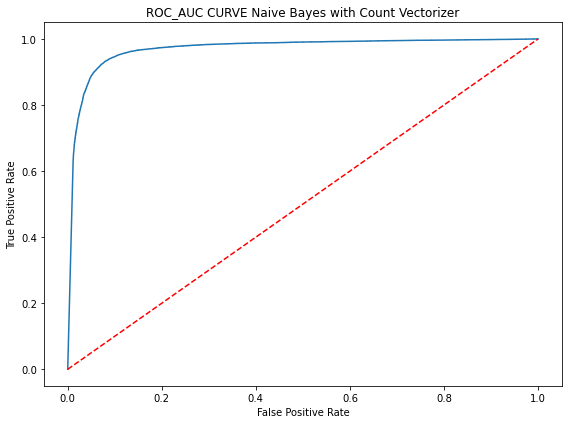

In [19]:
y_pred_proba1 = nbcv.predict_proba(X_test1)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test1,  y_pred_proba1)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr1,tpr1)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Naive Bayes with Count Vectorizer")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC Naive Bayes with Count Vectorizer.png')

# Step 4b: Naive Bayes with Count Vectorizer - All Features

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
scaler = MinMaxScaler()
scaler.fit(df1)
df_scaled = scaler.transform(df1)
scaled_features_df = pd.DataFrame(df_scaled, index=df1.index, columns=df1.columns)

In [21]:
scaled_features_df.head()

,length,sentiment,flesch_kincaid,repetition,class
0,0.000574,0.550000,0.000241,0.000000,1.0
1,0.000113,0.550000,0.000145,0.000000,0.0
2,0.000078,0.237500,0.000133,0.000000,0.0
3,0.000048,0.354167,0.000085,0.000000,1.0
4,0.002135,0.385769,0.000538,0.000257,1.0


In [22]:
scaled_features_df['length'].min()

0.0

In [23]:
from scipy.sparse import hstack
vectorizer = CountVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
text_matrix = vectorizer.fit_transform(df['clean_text'])
text_matrix = text_matrix.tocsc() 
length = scaled_features_df['length'].values[:, None]
sentiment = scaled_features_df['sentiment'].values[:, None]
reading_level = scaled_features_df['flesch_kincaid'][:, None]
repetition = scaled_features_df['repetition'][:, None]
first = hstack((text_matrix, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X = hstack((third, sentiment))

y = df['class']

In [24]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.25, random_state=12)

In [25]:
alphas = [0.025, 0.05, 0.1, 0.2, 0.4, 0.5, 0.75, 1, 2, 5, 8]
param_grid = {'alpha':alphas}
nbcv = MultinomialNB()
nbcv_cv= GridSearchCV(nbcv,param_grid,cv=5)
nbcv_cv.fit(X_train2, y_train2)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.025, 0.05, 0.1, 0.2, 0.4, 0.5, 0.75, 1, 2,
                                   5, 8]})

In [26]:
print("Best Score:" + str(nbcv_cv.best_score_))
print("Best Parameters: " + str(nbcv_cv.best_params_))

Best Score:0.9209473955331596
Best Parameters: {'alpha': 0.5}


In [27]:
nbcvi = MultinomialNB(alpha = 0.5)
nbcvi.fit(X_train2, y_train2)

MultinomialNB(alpha=0.5)

In [28]:
y_train_pred2 = nbcvi.predict(X_train2)
y_pred2 = nbcvi.predict(X_test2)

In [29]:
accuracy_nbcvi = metrics.accuracy_score(y_test2,y_pred2)
balanced_accuracy_nbcvi = metrics.balanced_accuracy_score(y_test2,y_pred2)
precision_nbcvi = metrics.precision_score(y_test2,y_pred2, pos_label = 1)
recall_nbcvi = metrics.recall_score(y_test2,y_pred2, pos_label = 1)
f1_nbcvi = metrics.f1_score(y_test2, y_pred2, pos_label = 1)
roc_auc_nbcvi = metrics.roc_auc_score(y_test2, y_pred2)
print("Accuracy:", accuracy_nbcvi)
print("Balanced accuracy:", balanced_accuracy_nbcvi)
print('Precision score' , precision_nbcvi)
print('Recall score' , recall_nbcvi)
print('F1 score' , f1_nbcvi)
print('ROC_AUC Score' , roc_auc_nbcvi)

Accuracy: 0.9226035543757434
Balanced accuracy: 0.922636977909941
Precision score 0.9026219692732835
Recall score 0.9471812752442434
F1 score 0.9243649349774273
ROC_AUC Score 0.922636977909941


In [30]:
from sklearn.metrics import confusion_matrix
tn_nbcvi, fp_nbcvi, fn_nbcvi, tp_nbcvi = confusion_matrix(y_test2, y_pred2).ravel()
print(f'True Suicide: {tp_nbcvi}')
print(f'False Suicide: {fp_nbcvi}')
print(f'True Non-Suicide: {tn_nbcvi}')
print(f'False Non-Suicide: {fn_nbcvi}')

True Suicide: 27437
False Suicide: 2960
True Non-Suicide: 26086
False Non-Suicide: 1530


In [31]:
pd.DataFrame(confusion_matrix(y_test2, y_pred2), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,26086,2960
Actual Suicide,1530,27437


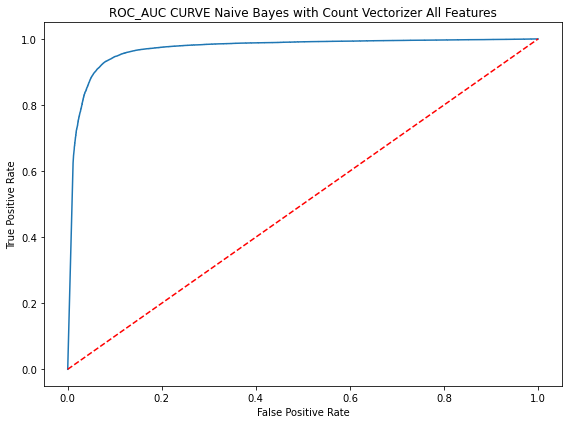

In [32]:
y_pred_proba2 = nbcvi.predict_proba(X_test2)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test2,  y_pred_proba2)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr2,tpr2)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Naive Bayes with Count Vectorizer All Features")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC Naive Bayes with Count Vectorizer All features.png')

# Step 4c: Nave Bayes with TF-IDF - Text Only

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizor_tfid = TfidfVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
X_tfid1 = vectorizor_tfid.fit_transform(df['text'])
X_tfid1 = X_tfid1.tocsc() 
y_tfid1 = df['class']

In [34]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_tfid1, y_tfid1, test_size=0.25, random_state=12)

In [35]:
alphas = [0.025, 0.05, 0.1, 0.2, 0.4, 0.5, 0.75, 1, 2, 5, 8]
param_grid = {'alpha':alphas}
nb_tfidf = MultinomialNB()
nb_tfidf_cv= GridSearchCV(nb_tfidf,param_grid,cv=5)
nb_tfidf_cv.fit(X_train3, y_train3)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.025, 0.05, 0.1, 0.2, 0.4, 0.5, 0.75, 1, 2,
                                   5, 8]})

In [36]:
print("Best Score:" + str(nb_tfidf_cv.best_score_))
print("Best Parameters: " + str(nb_tfidf_cv.best_params_))

Best Score:0.921062314615769
Best Parameters: {'alpha': 0.1}


In [37]:

nb_tfidf = MultinomialNB(alpha = 0.1)
nb_tfidf.fit(X_train3, y_train3)

MultinomialNB(alpha=0.1)

In [38]:
y_train_pred3 = nb_tfidf.predict(X_train3)
y_pred3 = nb_tfidf.predict(X_test3)

In [39]:
from sklearn import tree, metrics
accuracy_nb_tfidf = metrics.accuracy_score(y_test3,y_pred3)
balanced_accuracy_nb_tfidf = metrics.balanced_accuracy_score(y_test3,y_pred3)
precision_nb_tfidf = metrics.precision_score(y_test3,y_pred3, pos_label = 1)
recall_nb_tfidf = metrics.recall_score(y_test3,y_pred3, pos_label = 1)
f1_nb_tfidf = metrics.f1_score(y_test3, y_pred3, pos_label = 1)
roc_auc_nb_tfidf = metrics.roc_auc_score(y_test3, y_pred3)
print("Accuracy:", accuracy_nb_tfidf)
print("Balanced accuracy:", balanced_accuracy_nb_tfidf)
print('Precision score' , precision_nb_tfidf)
print('Recall score' , recall_nb_tfidf)
print('F1 score' , f1_nb_tfidf)
print('ROC_AUC Score' , roc_auc_nb_tfidf)



Accuracy: 0.9228448795959526
Balanced accuracy: 0.922899148016771
Precision score 0.8914176122742529
Recall score 0.9627507163323782
F1 score 0.9257120095598487
ROC_AUC Score 0.9228991480167709


In [40]:
from sklearn.metrics import confusion_matrix
tn_nb_tfidf, fp_nb_tfidf, fn_nb_tfidf, tp_nb_tfidf = confusion_matrix(y_test3, y_pred3).ravel()
print(f'True Suicide: {tp_nb_tfidf}')
print(f'False Suicide: {fp_nb_tfidf}')
print(f'True Non-Suicide: {tn_nb_tfidf}')
print(f'False Non-Suicide: {fn_nb_tfidf}')

True Suicide: 27888
False Suicide: 3397
True Non-Suicide: 25649
False Non-Suicide: 1079


In [41]:
pd.DataFrame(confusion_matrix(y_test3, y_pred3), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,25649,3397
Actual Suicide,1079,27888


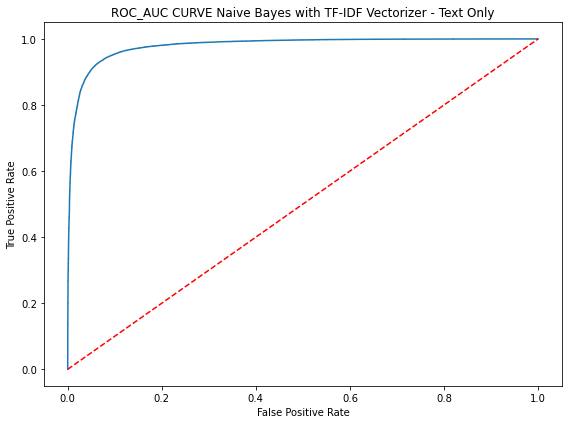

In [42]:
y_pred_proba3 = nb_tfidf.predict_proba(X_test3)[::,1]
fpr3, tpr3, _ = metrics.roc_curve(y_test3,  y_pred_proba3)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr3,tpr3)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Naive Bayes with TF-IDF Vectorizer - Text Only")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC Curve Naive Bayes with TF-IDF Vectoizer_Text_Only.png')

# Step 4d:  Naive Bayes - TF-IDF - All Features

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizor_tfid = TfidfVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
text_matrix1 = vectorizor_tfid.fit_transform(df['text'])
text_matrix1 = text_matrix1.tocsc() 
length = scaled_features_df['length'].values[:, None]
sentiment = scaled_features_df['sentiment'].values[:, None]
reading_level = scaled_features_df['flesch_kincaid'][:, None]
repetition = scaled_features_df['repetition'][:, None]
first = hstack((text_matrix1, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X_tfid11 = hstack((third, sentiment))

y_tfid11 = df['class']

In [44]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_tfid11, y_tfid11, test_size=0.25, random_state=12)

In [45]:
alphas = [0.025, 0.05, 0.1, 0.2, 0.4, 0.5, 0.75, 1, 2, 5, 8]
param_grid = {'alpha':alphas}
nb_tfidf = MultinomialNB()
nb_tfidf_cv= GridSearchCV(nb_tfidf,param_grid,cv=5)
nb_tfidf_cv.fit(X_train4, y_train4)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.025, 0.05, 0.1, 0.2, 0.4, 0.5, 0.75, 1, 2,
                                   5, 8]})

In [46]:
print("Best Score:" + str(nb_tfidf_cv.best_score_))
print("Best Parameters: " + str(nb_tfidf_cv.best_params_))

Best Score:0.9244639137163603
Best Parameters: {'alpha': 0.2}


In [47]:
nb_tfidf = MultinomialNB(alpha = 0.2)
nb_tfidf.fit(X_train4, y_train4)

MultinomialNB(alpha=0.2)

In [48]:
y_train_pred4 = nb_tfidf.predict(X_train4)
y_pred4 = nb_tfidf.predict(X_test4)

In [49]:
accuracy_nb_tfidfi = metrics.accuracy_score(y_test4,y_pred4)
balanced_accuracy_nb_tfidfi = metrics.balanced_accuracy_score(y_test4,y_pred4)
precision_nb_tfidfi = metrics.precision_score(y_test4,y_pred4, pos_label = 1)
recall_nb_tfidfi = metrics.recall_score(y_test4,y_pred4, pos_label = 1)
f1_nb_tfidfi = metrics.f1_score(y_test4, y_pred4, pos_label = 1)
roc_auc_nb_tfidfi = metrics.roc_auc_score(y_test4, y_pred4)
print("Accuracy:", accuracy_nb_tfidfi)
print("Balanced accuracy:", balanced_accuracy_nb_tfidfi)
print('Precision score' , precision_nb_tfidfi)
print('Recall score' , recall_nb_tfidfi)
print('F1 score' , f1_nb_tfidfi)
print('ROC_AUC Score' , roc_auc_nb_tfidfi)

Accuracy: 0.926344095288987
Balanced accuracy: 0.9263839809632104
Precision score 0.9025495565988524
Recall score 0.9556736976559533
F1 score 0.9283522527205352
ROC_AUC Score 0.9263839809632105


In [50]:
from sklearn.metrics import confusion_matrix
tn_nb_tfidfi, fp_nb_tfidfi, fn_nb_tfidfi, tp_nb_tfidfi = confusion_matrix(y_test4, y_pred4).ravel()
print(f'True Suicide: {tp_nb_tfidfi}')
print(f'False Suicide: {fp_nb_tfidfi}')
print(f'True Non-Suicide: {tn_nb_tfidfi}')
print(f'False Non-Suicide: {fn_nb_tfidfi}')

True Suicide: 27683
False Suicide: 2989
True Non-Suicide: 26057
False Non-Suicide: 1284


In [51]:
pd.DataFrame(confusion_matrix(y_test4, y_pred4), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,26057,2989
Actual Suicide,1284,27683


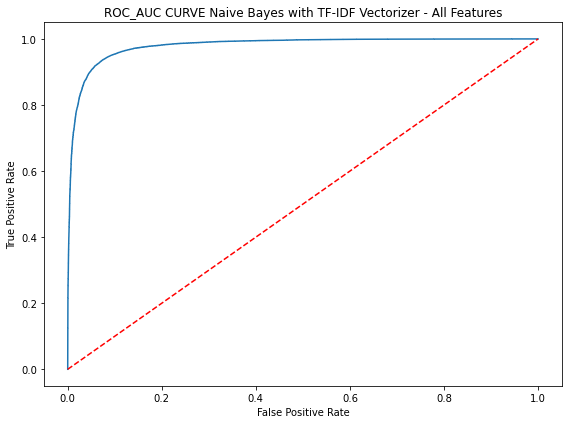

In [52]:
y_pred_proba4 = nb_tfidf.predict_proba(X_test4)[::,1]
fpr4, tpr4, _ = metrics.roc_curve(y_test4,  y_pred_proba4)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr4,tpr4)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Naive Bayes with TF-IDF Vectorizer - All Features")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC Curve Naive Bayes with TF-IDF Vectorizer_All_Features.png')

# Step 4e:  Random Forest with Count Vectorizor - Text Only

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
vectorizer = CountVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
X = vectorizer.fit_transform(df['clean_text'].head(1000))
X = X.tocsc() 
y = df['class'].head(1000)

In [55]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=0.25, random_state=12)

In [56]:
n_est = [int(n) for n in np.logspace(start=1.5, stop=3.4, num=5)]
n_est

[31, 94, 281, 841, 2511]

In [57]:

n_est = [int(n) for n in np.logspace(start=1.5, stop=3.4, num=5)]
depth = [int(x) for x in np.linspace(10, 100, num = 6)]
param_grid = {'n_estimators': n_est, 'max_depth' : depth}
rf1 = RandomForestClassifier(random_state = 1519)
rf_cv = GridSearchCV(rf1, param_grid, cv = 5)
rf_cv.fit(X_train5, y_train5)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1519),
             param_grid={'max_depth': [10, 28, 46, 64, 82, 100],
                         'n_estimators': [31, 94, 281, 841, 2511]})

In [58]:
print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Score:0.8480000000000001
Best Parameters: {'max_depth': 28, 'n_estimators': 841}


In [59]:
vectorizer = CountVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
X = vectorizer.fit_transform(df['clean_text'])
X = X.tocsc() 
y = df['class']

In [60]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=0.25, random_state=12)

In [61]:
rfcv = RandomForestClassifier(n_estimators = 841 , max_depth = 28)
rfcv.fit(X_train5, y_train5)

RandomForestClassifier(max_depth=28, n_estimators=841)

In [62]:
y_train_pred_rfcv = rfcv.predict(X_train5)
y_pred5 = rfcv.predict(X_test5)

In [63]:
from sklearn import tree, metrics
accuracy_rfcv = metrics.accuracy_score(y_test5,y_pred5)
balanced_accuracy_rfcv = metrics.balanced_accuracy_score(y_test5,y_pred5)
precision_rfcv = metrics.precision_score(y_test5,y_pred5, pos_label = 1)
recall_rfcv = metrics.recall_score(y_test5,y_pred5, pos_label = 1)
f1_rfcv = metrics.f1_score(y_test5, y_pred5, pos_label = 1)
roc_auc_rfcv = metrics.roc_auc_score(y_test5, y_pred5)
print("Accuracy:", accuracy_rfcv)
print("Balanced accuracy:", balanced_accuracy_rfcv)
print('Precision score' , precision_rfcv)
print('Recall score' , recall_rfcv)
print('F1 score' , f1_rfcv)
print('ROC_AUC Score' , roc_auc_rfcv)


Accuracy: 0.8251943529898471
Balanced accuracy: 0.8250671547379367
Precision score 0.8994991936168407
Recall score 0.7316601650153624
F1 score 0.8069447352890784
ROC_AUC Score 0.8250671547379367


In [64]:
from sklearn.metrics import confusion_matrix
tn_rfcv, fp_rfcv, fn_rfcv, tp_rfcv = confusion_matrix(y_test5, y_pred5).ravel()
print(f'True Suicide: {tp_rfcv}')
print(f'False Suicide: {fp_rfcv}')
print(f'True Non-Suicide: {tn_rfcv}')
print(f'False Non-Suicide: {fn_rfcv}')

True Suicide: 21194
False Suicide: 2368
True Non-Suicide: 26678
False Non-Suicide: 7773


In [65]:
pd.DataFrame(confusion_matrix(y_test5, y_pred5), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,26678,2368
Actual Suicide,7773,21194


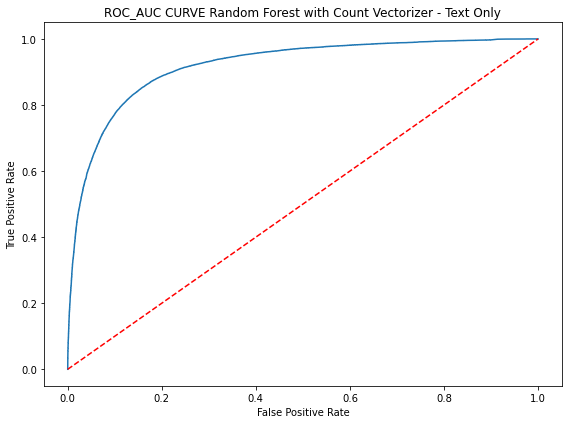

In [66]:
y_pred_proba5 = rfcv.predict_proba(X_test5)[::,1]
fpr5, tpr5, _ = metrics.roc_curve(y_test5,  y_pred_proba5)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr5,tpr5)
plt.plot([0, 1], [0, 1],'r--')

plt.title("ROC_AUC CURVE Random Forest with Count Vectorizer - Text Only")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC Curve Random Forest with Count Vectorizer TextOnly.png')

# Step 4f:  Random Forest with Count Vectorizer - All Features

In [67]:
from scipy.sparse import hstack
vectorizer = CountVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
text_matrix = vectorizer.fit_transform(df['clean_text'])
text_matrix = text_matrix.tocsc() 
length = scaled_features_df['length'].values[:, None]
sentiment = scaled_features_df['sentiment'].values[:, None]
reading_level = scaled_features_df['flesch_kincaid'][:, None]
repetition = scaled_features_df['repetition'][:, None]
first = hstack((text_matrix, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X = hstack((third, sentiment))

y = df['class']

In [68]:
X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=0.25, random_state=12)

In [69]:
from scipy.sparse import hstack
vectorizer = CountVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
text_matrix = vectorizer.fit_transform(df['clean_text'].head(1000))
text_matrix = text_matrix.tocsc() 
length = scaled_features_df['length'].head(1000).values[:, None]
sentiment = scaled_features_df['sentiment'].head(1000).values[:, None]
reading_level = scaled_features_df['flesch_kincaid'].head(1000)[:, None]
repetition = scaled_features_df['repetition'].head(1000)[:, None]
first = hstack((text_matrix, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X_param = hstack((third, sentiment))

y_param = df['class'].head(1000)

In [70]:
X_train_param, X_test_param, y_train_param, y_test_param = train_test_split(X_param, y_param, test_size=0.25, random_state=12)

In [71]:

n_est = [int(n) for n in np.logspace(start=2.5, stop=4, num=5)]
depth = [int(x) for x in np.linspace(10, 100, num = 10)]
param_grid = {'n_estimators': n_est, 'max_depth' : depth}
rf1 = RandomForestClassifier(random_state = 1519)
rf_cv = GridSearchCV(rf1, param_grid, cv = 5)
rf_cv.fit(X_train_param, y_train_param)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1519),
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'n_estimators': [316, 749, 1778, 4216, 10000]})

In [72]:
print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Score:0.8373333333333335
Best Parameters: {'max_depth': 40, 'n_estimators': 749}


In [73]:
rfcvi = RandomForestClassifier(n_estimators = 749 , max_depth = 40)
rfcvi.fit(X_train6, y_train6)

RandomForestClassifier(max_depth=40, n_estimators=749)

In [74]:
y_train_pred_rfcvi = rfcvi.predict(X_train6)
y_pred6 = rfcvi.predict(X_test6)

In [75]:
from sklearn import tree, metrics
accuracy_rfcvi = metrics.accuracy_score(y_test6,y_pred6)
balanced_accuracy_rfcvi = metrics.balanced_accuracy_score(y_test6,y_pred6)
precision_rfcvi = metrics.precision_score(y_test6,y_pred6, pos_label = 1)
recall_rfcvi = metrics.recall_score(y_test6,y_pred6, pos_label = 1)
f1_rfcvi = metrics.f1_score(y_test6, y_pred6, pos_label = 1)
roc_auc_rfcvi = metrics.roc_auc_score(y_test6, y_pred6)
print("Accuracy:", accuracy_rfcvi)
print("Balanced accuracy:", balanced_accuracy_rfcvi)
print('Precision score' , precision_rfcvi)
print('Recall score' , recall_rfcvi)
print('F1 score' , f1_rfcvi)
print('ROC_AUC Score' , roc_auc_rfcvi)


Accuracy: 0.8315549962939341
Balanced accuracy: 0.8314510720434803
Precision score 0.8908890970553497
Recall score 0.7551351537956985
F1 score 0.8174140508221226
ROC_AUC Score 0.8314510720434805


In [76]:
from sklearn.metrics import confusion_matrix
tn_rfcvi, fp_rfcvi, fn_rfcvi, tp_rfcvi = confusion_matrix(y_test6, y_pred6).ravel()
print(f'True Suicide: {tp_rfcvi}')
print(f'False Suicide: {fp_rfcvi}')
print(f'True Non-Suicide: {tn_rfcvi}')
print(f'False Non-Suicide: {fn_rfcvi}')

True Suicide: 21874
False Suicide: 2679
True Non-Suicide: 26367
False Non-Suicide: 7093


In [77]:
pd.DataFrame(confusion_matrix(y_test6, y_pred6), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,26367,2679
Actual Suicide,7093,21874


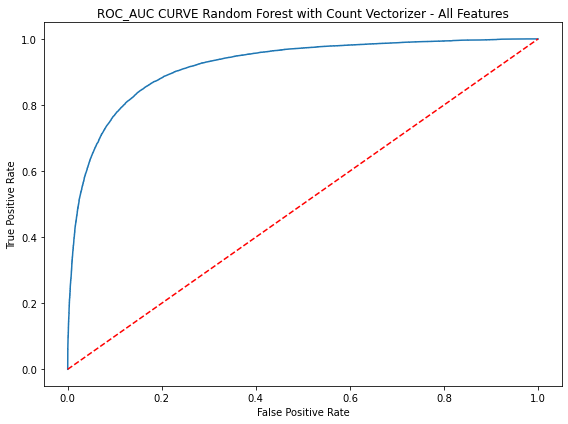

In [78]:
y_pred_proba6 = rfcvi.predict_proba(X_test6)[::,1]
fpr6, tpr6, _ = metrics.roc_curve(y_test6,  y_pred_proba6)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr6,tpr6)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Random Forest with Count Vectorizer - All Features")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC Curve Random Forest with Count Vectorizer All Features.png')

# Step 4g:  Random Forest with TF-IDF - Text Only

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizor_tfid = TfidfVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
X_tfid1 = vectorizor_tfid.fit_transform(df['text'])
X_tfid1 = X_tfid1.tocsc() 
y_tfid1 = df['class']

In [80]:
X_train7, X_test7, y_train7, y_test7 = train_test_split(X_tfid1, y_tfid1, test_size=0.25, random_state=12)

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizor_tfid = TfidfVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
X_params = vectorizor_tfid.fit_transform(df['text'].head(1000))
X_params = X_params.tocsc() 
y_params = df['class'].head(1000)

In [82]:
X_train_params7, X_test_params7, y_train_params7, y_test_params7 = train_test_split(X_params, y_params, test_size=0.25, random_state=12)

In [83]:

n_est = [int(n) for n in np.logspace(start=1.5, stop=2.5, num=5)]
depth = [int(x) for x in np.linspace(20, 100, num = 5)]
param_grid = {'n_estimators': n_est, 'max_depth' : depth}
rf1 = RandomForestClassifier(random_state = 1519)
rf_cv = GridSearchCV(rf1, param_grid, cv = 5)
rf_cv.fit(X_train_params7, y_train_params7)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1519),
             param_grid={'max_depth': [20, 40, 60, 80, 100],
                         'n_estimators': [31, 56, 100, 177, 316]})

In [84]:
print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Score:0.852
Best Parameters: {'max_depth': 40, 'n_estimators': 100}


In [85]:
rf_tfidf = RandomForestClassifier(max_depth = 40 , n_estimators = 100)
rf_tfidf.fit(X_train7, y_train7)


RandomForestClassifier(max_depth=40)

In [86]:
y_train_pred7 = rf_tfidf.predict(X_train7)
y_pred7 = rf_tfidf.predict(X_test7)

In [87]:
from sklearn import tree, metrics

accuracy_rf_tfidf = metrics.accuracy_score(y_test7,y_pred7)
balanced_accuracy_rf_tfidf = metrics.balanced_accuracy_score(y_test7,y_pred7)
precision_rf_tfidf = metrics.precision_score(y_test7,y_pred7, pos_label = 1)
recall_rf_tfidf = metrics.recall_score(y_test7,y_pred7, pos_label = 1)
f1_rf_tfidf = metrics.f1_score(y_test7, y_pred7, pos_label = 1)
roc_auc_rf_tfidf = metrics.roc_auc_score(y_test7, y_pred7)
print("Accuracy:", accuracy_rf_tfidf)
print("Balanced accuracy:", balanced_accuracy_rf_tfidf)
print('Precision score' , precision_rf_tfidf)
print('Recall score' , recall_rf_tfidf)
print('F1 score' , f1_rf_tfidf)
print('ROC_AUC Score' , roc_auc_rf_tfidf)



Accuracy: 0.8313826211366417
Balanced accuracy: 0.8312697766488993
Precision score 0.8968270384313076
Recall score 0.7484033555425139
F1 score 0.8159202107640195
ROC_AUC Score 0.8312697766488993


In [88]:
from sklearn.metrics import confusion_matrix
tn_rf_tfid, fp_rf_tfid, fn_rf_tfid, tp_rf_tfid = confusion_matrix(y_test7, y_pred7).ravel()
print(f'True Suicide: {tp_rf_tfid}')
print(f'False Suicide: {fp_rf_tfid}')
print(f'True Non-Suicide: {tn_rf_tfid}')
print(f'False Non-Suicide: {fn_rf_tfid}')

True Suicide: 21679
False Suicide: 2494
True Non-Suicide: 26552
False Non-Suicide: 7288


In [89]:
pd.DataFrame(confusion_matrix(y_test7, y_pred7), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,26552,2494
Actual Suicide,7288,21679


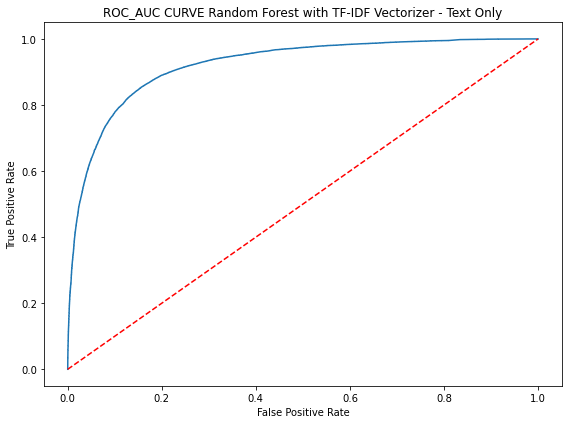

In [90]:
y_pred_proba7 = rf_tfidf.predict_proba(X_test7)[::,1]
fpr7, tpr7, _ = metrics.roc_curve(y_test7,  y_pred_proba7)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr7,tpr7)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Random Forest with TF-IDF Vectorizer - Text Only")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC Curve Random Forest with TF-IDF_text_only.png')

# Step 4h:  Random Forest with TF-IDF - All Features

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizor_tfid = TfidfVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
text_matrix8 = vectorizor_tfid.fit_transform(df['text'])
text_matrix8 = text_matrix8.tocsc() 
length = scaled_features_df['length'].values[:, None]
sentiment = scaled_features_df['sentiment'].values[:, None]
reading_level = scaled_features_df['flesch_kincaid'][:, None]
repetition = scaled_features_df['repetition'][:, None]
first = hstack((text_matrix8, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X_tfid8 = hstack((third, sentiment))

y_tfid8 = df['class']

In [92]:
X_train8, X_test8, y_train8, y_test8 = train_test_split(X_tfid8, y_tfid8, test_size=0.25, random_state=12)

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizor_tfid = TfidfVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
text_matrix8 = vectorizor_tfid.fit_transform(df['text'].head(1000))
text_matrix8 = text_matrix8.tocsc() 
length = scaled_features_df['length'].head(1000).values[:, None]
sentiment = scaled_features_df['sentiment'].head(1000).values[:, None]
reading_level = scaled_features_df['flesch_kincaid'].head(1000)[:, None]
repetition = scaled_features_df['repetition'].head(1000)[:, None]
first = hstack((text_matrix8, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X_param8 = hstack((third, sentiment))

y_param8 = df['class'].head(1000)


In [94]:
X_train_param8, X_test_param8, y_train_param8, y_test_param8 = train_test_split(X_param8, y_param8, test_size=0.25, random_state=12)

In [95]:
n_est = [int(n) for n in np.logspace(start=1.6, stop=4.4, num=5)]
n_est

[39, 199, 1000, 5011, 25118]

In [96]:

n_est = [int(n) for n in np.logspace(start=1.6, stop=4.4, num=5)]
depth = [int(x) for x in np.linspace(10, 100, num = 6)]
param_grid = {'n_estimators': n_est, 'max_depth' : depth}
rf1 = RandomForestClassifier(random_state = 1519)
rf_cv = GridSearchCV(rf1, param_grid, cv = 5)
rf_cv.fit(X_train_param8, y_train_param8)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1519),
             param_grid={'max_depth': [10, 28, 46, 64, 82, 100],
                         'n_estimators': [39, 199, 1000, 5011, 25118]})

In [97]:

print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))


Best Score:0.8466666666666667
Best Parameters: {'max_depth': 28, 'n_estimators': 5011}


In [98]:
rf_tfidfi = RandomForestClassifier(max_depth = 28, n_estimators = 5011)
rf_tfidfi.fit(X_train8, y_train8)

RandomForestClassifier(max_depth=28, n_estimators=5011)

In [99]:
y_train_pred8 = rf_tfidfi.predict(X_train8)
y_pred8 = rf_tfidfi.predict(X_test8)

In [100]:

accuracy_rf_tfidfi = metrics.accuracy_score(y_test8,y_pred8)
balanced_accuracy_rf_tfidfi = metrics.balanced_accuracy_score(y_test8,y_pred8)
precision_rf_tfidfi = metrics.precision_score(y_test8,y_pred8, pos_label = 1)
recall_rf_tfidfi = metrics.recall_score(y_test8,y_pred8, pos_label = 1)
f1_rf_tfidfi = metrics.f1_score(y_test8, y_pred8, pos_label = 1)
roc_auc_rf_tfidfi = metrics.roc_auc_score(y_test8, y_pred8)
print("Accuracy:", accuracy_rf_tfidfi)
print("Balanced accuracy:", balanced_accuracy_rf_tfidfi)
print('Precision score' , precision_rf_tfidfi)
print('Recall score' , recall_rf_tfidfi)
print('F1 score' , f1_rf_tfidfi)
print('ROC_AUC Score' , roc_auc_rf_tfidfi)


Accuracy: 0.8219192250012928
Balanced accuracy: 0.821795823377701
Precision score 0.892766818411735
Recall score 0.7311768564228259
F1 score 0.8039323603651478
ROC_AUC Score 0.821795823377701


In [101]:
from sklearn.metrics import confusion_matrix
tn_rf_tfidi, fp_rf_tfidi, fn_rf_tfidi, tp_rf_tfidi = confusion_matrix(y_test8, y_pred8).ravel()
print(f'True Suicide: {tp_rf_tfidi}')
print(f'False Suicide: {fp_rf_tfidi}')
print(f'True Non-Suicide: {tn_rf_tfidi}')
print(f'False Non-Suicide: {fn_rf_tfidi}')

True Suicide: 21180
False Suicide: 2544
True Non-Suicide: 26502
False Non-Suicide: 7787


In [102]:
pd.DataFrame(confusion_matrix(y_test8, y_pred8), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,26502,2544
Actual Suicide,7787,21180


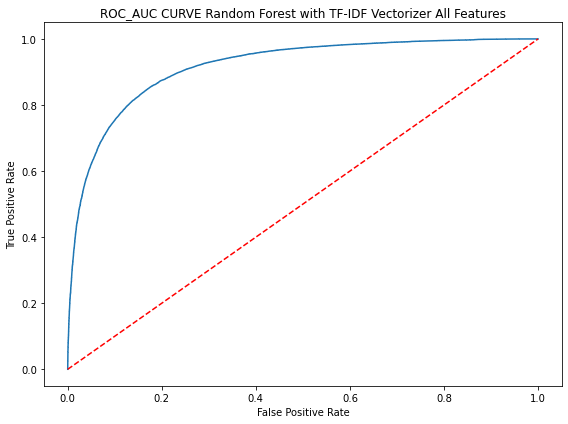

In [103]:
y_pred_proba8 = rf_tfidfi.predict_proba(X_test8)[::,1]
fpr8, tpr8, _ = metrics.roc_curve(y_test8,  y_pred_proba8)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr8,tpr8)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Random Forest with TF-IDF Vectorizer All Features")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC Curve Random Forest with TF-IDF.ALL_Features.png')

# Step 4i:  Logistic Regression with Count Vectorizer - Text Only

In [104]:
vectorizer = CountVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
X = vectorizer.fit_transform(df['clean_text'])
X = X.tocsc() 
y = df['class']

In [105]:
X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=0.25, random_state=12)

In [106]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train9, y_train9)

LogisticRegression()

In [107]:
#penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]
param_grid = {'C' : c_values}
lr = LogisticRegression(random_state = 0)
lr_cv = GridSearchCV(lr, param_grid, cv = 5)
lr_cv.fit(X_train9, y_train9)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01]})

In [108]:
print("Best Score:" + str(lr_cv.best_score_))
print("Best Parameters: " + str(lr_cv.best_params_))

Best Score:0.9322094344294982
Best Parameters: {'C': 1.0}


In [109]:
lr = LogisticRegression(C = 1.0)
lr.fit(X_train9, y_train9)

LogisticRegression()

In [110]:
y_train_pred = lr.predict(X_train9)
y_pred9 = lr.predict(X_test9)

In [111]:
from sklearn import tree, metrics

accuracy_lrcv = metrics.accuracy_score(y_test9,y_pred9)
balanced_accuracy_lrcv = metrics.balanced_accuracy_score(y_test9,y_pred9)
precision_lrcv = metrics.precision_score(y_test9,y_pred9, pos_label = 1)
recall_lrcv = metrics.recall_score(y_test9,y_pred9, pos_label = 1)
f1_lrcv = metrics.f1_score(y_test9, y_pred9, pos_label = 1)
roc_auc_lrcv = metrics.roc_auc_score(y_test9, y_pred9)
print("Accuracy:", accuracy_lrcv)
print("Balanced accuracy:", balanced_accuracy_lrcv)
print('Precision score' , precision_lrcv)
print('Recall score' , recall_lrcv)
print('F1 score' , f1_lrcv)
print('ROC_AUC Score' , roc_auc_lrcv)


Accuracy: 0.9347904779963112
Balanced accuracy: 0.9347704750445771
Precision score 0.9477951635846372
Recall score 0.9200814720198847
F1 score 0.9337327237374534
ROC_AUC Score 0.934770475044577


In [112]:
from sklearn.metrics import confusion_matrix
tn_lrcv, fp_lrcv, fn_lrcv, tp_lrcv = confusion_matrix(y_test9, y_pred9).ravel()
print(f'True Suicide: {tp_lrcv}')
print(f'False Suicide: {fp_lrcv}')
print(f'True Non-Suicide: {tn_lrcv}')
print(f'False Non-Suicide: {fn_lrcv}')

True Suicide: 26652
False Suicide: 1468
True Non-Suicide: 27578
False Non-Suicide: 2315


In [113]:
pd.DataFrame(confusion_matrix(y_test9, y_pred9), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,27578,1468
Actual Suicide,2315,26652


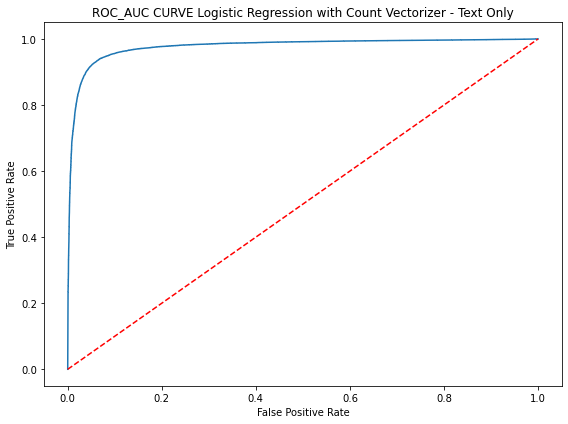

In [114]:
y_pred_proba9 = lr.predict_proba(X_test9)[::,1]
fpr9, tpr9, _ = metrics.roc_curve(y_test9,  y_pred_proba9)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr9,tpr9)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Logistic Regression with Count Vectorizer - Text Only")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC CURVE Logistic Regression with Count Vectorizer_TextOnly.png')

# Step 4j:  Logistic Regression with Count Vectorizer - All Features

In [115]:
from scipy.sparse import hstack
vectorizer = CountVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
text_matrix = vectorizer.fit_transform(df['clean_text'])
text_matrix = text_matrix.tocsc() 
length = scaled_features_df['length'].values[:, None]
sentiment = scaled_features_df['sentiment'].values[:, None]
reading_level = scaled_features_df['flesch_kincaid'][:, None]
repetition = scaled_features_df['repetition'][:, None]
first = hstack((text_matrix, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X = hstack((third, sentiment))

y = df['class']

In [116]:
X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=0.25, random_state=12)

In [117]:
#penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]
param_grid = {'C' : c_values}
lr = LogisticRegression(random_state = 0)
lr_cv = GridSearchCV(lr, param_grid, cv = 5)
lr_cv.fit(X_train10, y_train10)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01]})

In [118]:
print("Best Score:" + str(lr_cv.best_score_))
print("Best Parameters: " + str(lr_cv.best_params_))

Best Score:0.9321864521977072
Best Parameters: {'C': 1.0}


In [119]:
lrcvi = LogisticRegression(C = 1.0)
lrcvi.fit(X_train10, y_train10)

LogisticRegression()

In [120]:
y_train_pred10 = lrcvi.predict(X_train10)
y_pred10 = lrcvi.predict(X_test10)

In [121]:
accuracy_lrcvi = metrics.accuracy_score(y_test10,y_pred10)
balanced_accuracy_lrcvi = metrics.balanced_accuracy_score(y_test10,y_pred10)
precision_lrcvi = metrics.precision_score(y_test10,y_pred10, pos_label = 1)
recall_lrcvi = metrics.recall_score(y_test10,y_pred10, pos_label = 1)
f1_lrcvi = metrics.f1_score(y_test10, y_pred10, pos_label = 1)
roc_auc_lrcvi = metrics.roc_auc_score(y_test10, y_pred10)
print("Accuracy:", accuracy_lrcvi)
print("Balanced accuracy:", balanced_accuracy_lrcvi)
print('Precision score' , precision_lrcvi)
print('Recall score' , recall_lrcvi)
print('F1 score' , f1_lrcvi)
print('ROC_AUC Score' , roc_auc_lrcvi)


Accuracy: 0.935445503594022
Balanced accuracy: 0.9354256426977747
Precision score 0.9483751688828842
Recall score 0.9208409569510132
F1 score 0.9344052685968509
ROC_AUC Score 0.9354256426977747


In [122]:
from sklearn.metrics import confusion_matrix
tn_lrcvi, fp_lrcvi, fn_lrcvi, tp_lrcvi = confusion_matrix(y_test10, y_pred10).ravel()
print(f'True Suicide: {tp_lrcvi}')
print(f'False Suicide: {fp_lrcvi}')
print(f'True Non-Suicide: {tn_lrcvi}')
print(f'False Non-Suicide: {fn_lrcvi}')

True Suicide: 26674
False Suicide: 1452
True Non-Suicide: 27594
False Non-Suicide: 2293


In [123]:
pd.DataFrame(confusion_matrix(y_test10, y_pred10), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,27594,1452
Actual Suicide,2293,26674


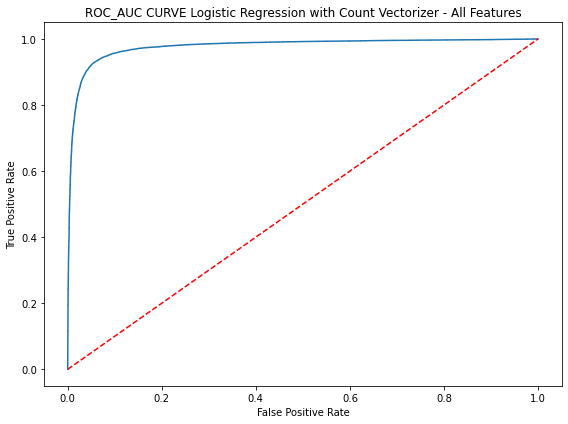

In [124]:
y_pred_proba10 = lrcvi.predict_proba(X_test10)[::,1]
fpr10, tpr10, _ = metrics.roc_curve(y_test10,  y_pred_proba10)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr10,tpr10)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Logistic Regression with Count Vectorizer - All Features")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC CURVE Logistic Regression with Count Vectorizer All Features.png')

# Step 4k:  Logistic Regression with TF-IDF - Text Only

In [125]:
vectorizor_tfid = TfidfVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
X = vectorizor_tfid.fit_transform(df['text'])
X_tfid11 = X.tocsc() 

y_tfid11 = df['class']

In [126]:
X_train11, X_test11, y_train11, y_test11 = train_test_split(X_tfid11, y_tfid11, test_size=0.25, random_state=12)

In [127]:
#penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]
param_grid = {'C' : c_values}
lr_tfid = LogisticRegression(random_state = 0)
lr_tfid_cv = GridSearchCV(lr_tfid, param_grid, cv = 5)
lr_tfid_cv.fit(X_train11, y_train11)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01]})

In [128]:
print("Best Score:" + str(lr_tfid_cv.best_score_))
print("Best Parameters: " + str(lr_tfid_cv.best_params_))

Best Score:0.9378749253269779
Best Parameters: {'C': 10}


In [129]:
lr_tfid = LogisticRegression(C = 10)
lr_tfid.fit(X_test11, y_test11)

LogisticRegression(C=10)

In [130]:
y_train_pred11 = lr_tfid.predict(X_train11)
y_pred11 = lr_tfid.predict(X_test11)

In [131]:
accuracy_lr_tfidf = metrics.accuracy_score(y_test11,y_pred11)
balanced_accuracy_lr_tfidf = metrics.balanced_accuracy_score(y_test11,y_pred11)
precision_lr_tfidf = metrics.precision_score(y_test11,y_pred11, pos_label = 1)
recall_lr_tfidf = metrics.recall_score(y_test11,y_pred11, pos_label = 1)
f1_lr_tfidf = metrics.f1_score(y_test11, y_pred11, pos_label = 1)
roc_auc_lr_tfidf = metrics.roc_auc_score(y_test11, y_pred11)
print("Accuracy:", accuracy_lr_tfidf)
print("Balanced accuracy:", balanced_accuracy_lr_tfidf)
print('Precision score' , precision_lr_tfidf)
print('Recall score' , recall_lr_tfidf)
print('F1 score' , f1_lr_tfidf)
print('ROC_AUC Score' , roc_auc_lr_tfidf)



Accuracy: 0.9954320583317532
Balanced accuracy: 0.9954333878485896
Precision score 0.9944528665931642
Recall score 0.9964097075983015
F1 score 0.9954303253953198
ROC_AUC Score 0.9954333878485897


In [132]:
from sklearn.metrics import confusion_matrix
tn_lr_tfid, fp_lr_tfid, fn_lr_tfid, tp_lr_tfid = confusion_matrix(y_test11, y_pred11).ravel()
print(f'True Suicide: {tp_lr_tfid}')
print(f'False Suicide: {fp_lr_tfid}')
print(f'True Non-Suicide: {tn_lr_tfid}')
print(f'False Non-Suicide: {fn_lr_tfid}')

True Suicide: 28863
False Suicide: 161
True Non-Suicide: 28885
False Non-Suicide: 104


In [133]:
pd.DataFrame(confusion_matrix(y_test11, y_pred11), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,28885,161
Actual Suicide,104,28863


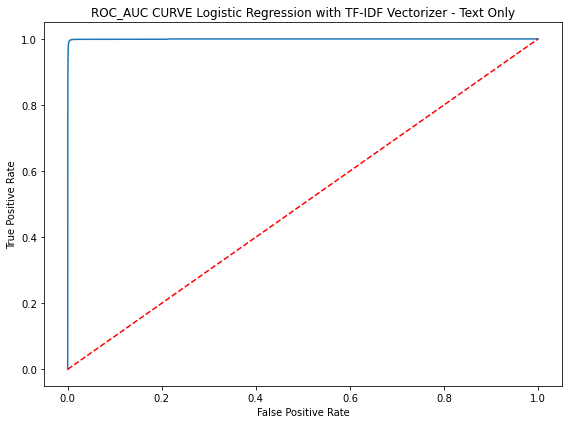

In [134]:
y_pred_proba11 = lr_tfid.predict_proba(X_test11)[::,1]
fpr11, tpr11, _ = metrics.roc_curve(y_test11,  y_pred_proba11)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr11,tpr11)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Logistic Regression with TF-IDF Vectorizer - Text Only")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC CURVE Logistic Regression with TF-IDF Vectorizer_Text_Only.png')

# Step 4l:  Logistic Regression with TF-IDF - All Features

In [135]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizor_tfid = TfidfVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
text_matrix12 = vectorizor_tfid.fit_transform(df['text'])
text_matrix12 = text_matrix12.tocsc() 
length = scaled_features_df['length'].values[:, None]
sentiment = scaled_features_df['sentiment'].values[:, None]
reading_level = scaled_features_df['flesch_kincaid'][:, None]
repetition = scaled_features_df['repetition'][:, None]
first = hstack((text_matrix12, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X_tfid12 = hstack((third, sentiment))

y_tfid12 = df['class']

In [136]:
X_train12, X_test12, y_train12, y_test12 = train_test_split(X_tfid12, y_tfid12, test_size=0.25, random_state=12)

In [137]:
#penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]
param_grid = {'C' : c_values}
lr_tfid = LogisticRegression(random_state = 0)
lr_tfid_cvi = GridSearchCV(lr_tfid, param_grid, cv = 5)
lr_tfid_cvi.fit(X_train12, y_train12)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01]})

In [138]:
print("Best Score:" + str(lr_tfid_cvi.best_score_))
print("Best Parameters: " + str(lr_tfid_cvi.best_params_))

Best Score:0.9380473085730244
Best Parameters: {'C': 10}


In [139]:
lr_tfidi = LogisticRegression(C = 10)
lr_tfidi.fit(X_test12, y_test12)

LogisticRegression(C=10)

In [140]:
y_train_pred12 = lr_tfidi.predict(X_train12)
y_pred12 = lr_tfidi.predict(X_test12)

In [141]:
accuracy_lr_tfidfi = metrics.accuracy_score(y_test12,y_pred12)
balanced_accuracy_lr_tfidfi = metrics.balanced_accuracy_score(y_test12,y_pred12)
precision_lr_tfidfi = metrics.precision_score(y_test12,y_pred12, pos_label = 1)
recall_lr_tfidfi = metrics.recall_score(y_test12,y_pred12, pos_label = 1)
f1_lr_tfidfi = metrics.f1_score(y_test12, y_pred12, pos_label = 1)
roc_auc_lr_tfidfi = metrics.roc_auc_score(y_test12, y_pred12)
print("Accuracy:", accuracy_lr_tfidfi)
print("Balanced accuracy:", balanced_accuracy_lr_tfidfi)
print('Precision score' , precision_lr_tfidfi)
print('Recall score' , recall_lr_tfidfi)
print('F1 score' , f1_lr_tfidfi)
print('ROC_AUC Score' , roc_auc_lr_tfidfi)


Accuracy: 0.9955699584575871
Balanced accuracy: 0.9955711473893412
Precision score 0.9946929492039424
Recall score 0.9964442296406255
F1 score 0.9955678192636027
ROC_AUC Score 0.9955711473893413


In [142]:
from sklearn.metrics import confusion_matrix
tn_lr_tfidi, fp_lr_tfidi, fn_lr_tfidi, tp_lr_tfidi = confusion_matrix(y_test12, y_pred12).ravel()
print(f'True Suicide: {tp_lr_tfidi}')
print(f'False Suicide: {fp_lr_tfidi}')
print(f'True Non-Suicide: {tn_lr_tfidi}')
print(f'False Non-Suicide: {fn_lr_tfidi}')

True Suicide: 28864
False Suicide: 154
True Non-Suicide: 28892
False Non-Suicide: 103


In [143]:
pd.DataFrame(confusion_matrix(y_test12, y_pred12), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,28892,154
Actual Suicide,103,28864


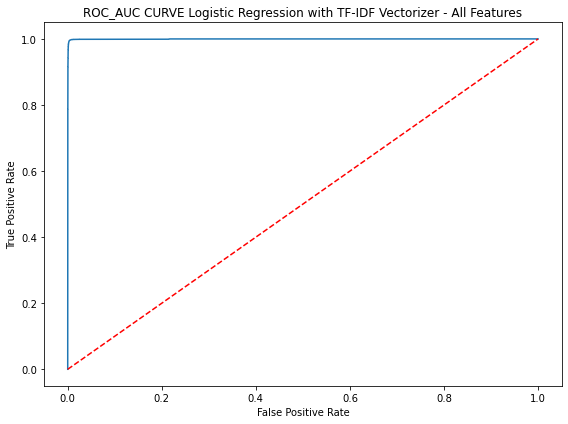

In [144]:
y_pred_proba12 = lr_tfidi.predict_proba(X_test12)[::,1]
fpr12, tpr12, _ = metrics.roc_curve(y_test12,  y_pred_proba12)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr12,tpr12)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Logistic Regression with TF-IDF Vectorizer - All Features")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC CURVE Logistic Regression with TF-IDF Vectorizer_All_Features.png')

# Step 5:  Compare the models

In [145]:
from tabulate import tabulate
d = [ ["Naive Bayes (Count Vectorizer - Text Only)",round(accuracy_nbcv, 3), round(precision_nbcv, 3), round(recall_nbcv, 3), round(f1_nbcv, 3), round(roc_auc_nbcv, 3)], 
     ["Naive Bayes (Count Vectorizer - All Features)",round(accuracy_nbcvi, 3), round(precision_nbcvi, 3), round(recall_nbcvi, 3), round(f1_nbcvi, 3), round(roc_auc_nbcvi, 3)], 
     
     ["Naive Bayes (TF-IDF - Text Only)",round(accuracy_nb_tfidf, 3), round(precision_nb_tfidf, 3), round(recall_nb_tfidf, 3), round(f1_nb_tfidf, 3), round(roc_auc_nb_tfidf, 3)],
    ["Naive Bayes (TF-IDF - All Features)",round(accuracy_nb_tfidfi, 3), round(precision_nb_tfidfi, 3), round(recall_nb_tfidfi, 3), round(f1_nb_tfidfi, 3), round(roc_auc_nb_tfidfi, 3)], ["", "", "" ,"", "", ""],
    ["Random Forest (Count Vectorizer - Text Only)",round(accuracy_rfcv, 3), round(precision_rfcv, 3), round(recall_rfcv, 3), round(f1_rfcv, 3), round(roc_auc_rfcv, 3)], 
    ["Random Forest (Count Vectorizer - All Features)",round(accuracy_rfcvi, 3), round(precision_rfcvi, 3), round(recall_rfcvi, 3), round(f1_rfcvi, 3), round(roc_auc_rfcvi, 3)], 
    ["Random Forest (TF-IDF - Text Only)",round(accuracy_rf_tfidf, 3), round(precision_rf_tfidf, 3), round(recall_rf_tfidf, 3), round(f1_rf_tfidf, 3), round(roc_auc_rf_tfidf, 3)], 
    ["Random Forest (TF-IDF - All Features)",round(accuracy_rf_tfidfi, 3), round(precision_rf_tfidfi, 3), round(recall_rf_tfidfi, 3), round(f1_rf_tfidfi, 3), round(roc_auc_rf_tfidfi, 3)], ["", "", "" ,"", "", ""],
    ["Logistic Regression (Count Vectorizer - Text Only)",round(accuracy_lrcv, 3), round(precision_lrcv, 3), round(recall_lrcv, 3), round(f1_lrcv, 3), round(roc_auc_lrcv, 3)], 
    ["Logistic Regression (Count Vectorizer - All Features)",round(accuracy_lrcvi, 3), round(precision_lrcvi, 3), round(recall_lrcvi, 3), round(f1_lrcvi, 3), round(roc_auc_lrcvi, 3)], 
    ["Logistic Regression (TF-IDF - Text Only)",round(accuracy_lr_tfidf, 3), round(precision_lr_tfidf, 3), round(recall_lr_tfidf, 3), round(f1_lr_tfidf, 3), round(roc_auc_lr_tfidf, 3)], 
    ["Logistic Regression (TF-IDF - All Features)",round(accuracy_lr_tfidfi, 3), round(precision_lr_tfidfi, 3), round(recall_lr_tfidfi, 3), round(f1_lr_tfidfi, 3), round(roc_auc_lr_tfidfi, 3)], ["", "", "" ,"", "", ""]]
print(" ")
print(" ")
datalist2 = tabulate(d, headers=["   Model  ", "Accuracy", "Precision", "Recall", "F1", "ROC_AUC"])
print(datalist2)

 
 
   Model                                               Accuracy    Precision    Recall    F1     ROC_AUC
-----------------------------------------------------  ----------  -----------  --------  -----  ---------
Naive Bayes (Count Vectorizer - Text Only)             0.919       0.89         0.956     0.922  0.919
Naive Bayes (Count Vectorizer - All Features)          0.923       0.903        0.947     0.924  0.923
Naive Bayes (TF-IDF - Text Only)                       0.923       0.891        0.963     0.926  0.923
Naive Bayes (TF-IDF - All Features)                    0.926       0.903        0.956     0.928  0.926

Random Forest (Count Vectorizer - Text Only)           0.825       0.899        0.732     0.807  0.825
Random Forest (Count Vectorizer - All Features)        0.832       0.891        0.755     0.817  0.831
Random Forest (TF-IDF - Text Only)                     0.831       0.897        0.748     0.816  0.831
Random Forest (TF-IDF - All Features)                  0.822  

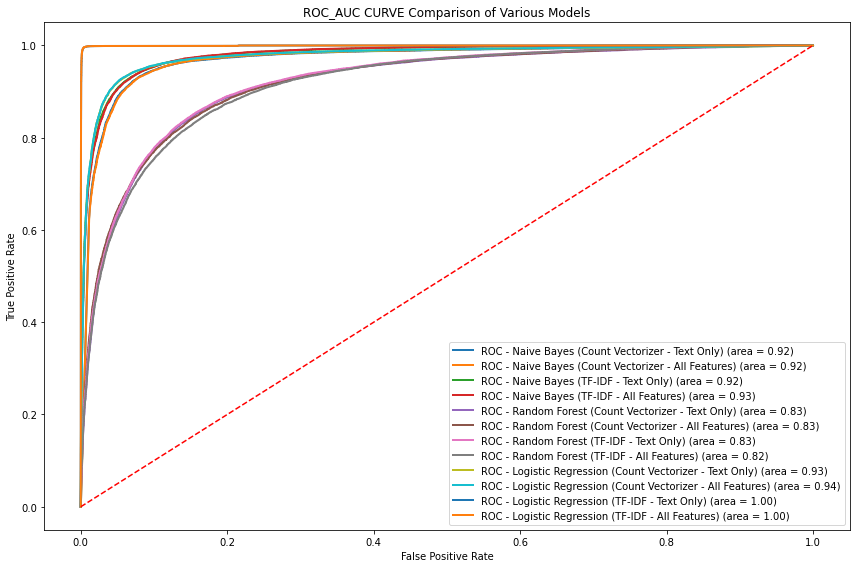

In [146]:
plt.figure(figsize=(12,8))

plt.plot(fpr1, tpr1, lw=2, label='ROC - Naive Bayes (Count Vectorizer - Text Only)' + ' (area = %0.2f)' % roc_auc_nbcv)
plt.plot(fpr2, tpr2, lw=2, label='ROC - Naive Bayes (Count Vectorizer - All Features)' + ' (area = %0.2f)' % roc_auc_nbcvi)
plt.plot(fpr3, tpr3, lw=2, label='ROC - Naive Bayes (TF-IDF - Text Only)' + ' (area = %0.2f)' % roc_auc_nb_tfidf)
plt.plot(fpr4, tpr4, lw=2, label='ROC - Naive Bayes (TF-IDF - All Features)' + ' (area = %0.2f)' % roc_auc_nb_tfidfi)
plt.plot(fpr5, tpr5, lw=2, label='ROC - Random Forest (Count Vectorizer - Text Only)' + ' (area = %0.2f)' % roc_auc_rfcv)
plt.plot(fpr6, tpr6, lw=2, label='ROC - Random Forest (Count Vectorizer - All Features)' + ' (area = %0.2f)' % roc_auc_rfcvi)
plt.plot(fpr7, tpr7, lw=2, label='ROC - Random Forest (TF-IDF - Text Only)' + ' (area = %0.2f)' % roc_auc_rf_tfidf)
plt.plot(fpr8, tpr8, lw=2, label='ROC - Random Forest (TF-IDF - All Features)' + ' (area = %0.2f)' % roc_auc_rf_tfidfi)
plt.plot(fpr9, tpr9, lw=2, label='ROC - Logistic Regression (Count Vectorizer - Text Only)' + ' (area = %0.2f)' % roc_auc_lrcv)
plt.plot(fpr10, tpr10, lw=2, label='ROC - Logistic Regression (Count Vectorizer - All Features)' + ' (area = %0.2f)' % roc_auc_lrcvi)
plt.plot(fpr11, tpr11, lw=2, label='ROC - Logistic Regression (TF-IDF - Text Only)' + ' (area = %0.2f)' % roc_auc_lr_tfidf)
plt.plot(fpr12, tpr12, lw=2, label='ROC - Logistic Regression (TF-IDF - All Features)' + ' (area = %0.2f)' % roc_auc_lr_tfidfi)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Comparison of Various Models")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('ROC_AUC CURVE Model Comparison.png')

In [147]:
d1 = [ ["Naive Bayes (Count Vectorizer - Text Only)",tp_nbcv, fp_nbcv, tn_nbcv, fn_nbcv], 
     ["Naive Bayes (Count Vectorizer - All Features)",tp_nbcvi, fp_nbcvi, tn_nbcvi, fn_nbcvi],      
     ["Naive Bayes (TF-IDF - Text Only)",tp_nb_tfidf, fp_nb_tfidf, tn_nb_tfidf, fn_nb_tfidf],
    ["Naive Bayes (TF-IDF - All Features)",tp_nb_tfidfi, fp_nb_tfidfi, tn_nb_tfidfi, fn_nb_tfidfi], ["", "", "" ,"", "", ""],
    ["Random Forest (Count Vectorizer - Text Only)",tp_rfcv, fp_rfcv, tn_rfcv, fn_rfcv], 
    ["Random Forest (Count Vectorizer - All Features)",tp_rfcvi, fp_rfcvi, tn_rfcvi, fn_rfcvi], 
    ["Random Forest (TF-IDF - Text Only)",tp_rf_tfid, fp_rf_tfid, tn_rf_tfid, fn_rf_tfid], 
    ["Random Forest (TF-IDF - All Features)",tp_rf_tfidi, fp_rf_tfidi, tn_rf_tfidi, fn_rf_tfidi], ["", "", "" ,"", "", ""],
    ["Logistic Regression (Count Vectorizer - Text Only)",tp_lrcv, fp_lrcv, tn_lrcv, fn_lrcv], 
    ["Logistic Regression (Count Vectorizer - All Features)",tp_lrcvi, fp_lrcvi, tn_lrcvi, fn_lrcvi], 
    ["Logistic Regression (TF-IDF - Text Only)",tp_lr_tfid, fp_lr_tfid, tn_lr_tfid, fn_lr_tfid], 
    ["Logistic Regression (TF-IDF - All Features)",tp_lr_tfidi, fp_lr_tfidi, tn_lr_tfidi, fn_lr_tfidi], ["", "", "" ,"", "", ""]]
print(" ")
print(" ")
datalist3 = tabulate(d1, headers=["   Model  ", "True Positive", "False Positive", "True Negative", "False Negative"])
print(datalist3)

 
 
   Model                                               True Positive    False Positive    True Negative    False Negative
-----------------------------------------------------  ---------------  ----------------  ---------------  ----------------
Naive Bayes (Count Vectorizer - Text Only)             27685            3409              25637            1282
Naive Bayes (Count Vectorizer - All Features)          27437            2960              26086            1530
Naive Bayes (TF-IDF - Text Only)                       27888            3397              25649            1079
Naive Bayes (TF-IDF - All Features)                    27683            2989              26057            1284

Random Forest (Count Vectorizer - Text Only)           21194            2368              26678            7773
Random Forest (Count Vectorizer - All Features)        21874            2679              26367            7093
Random Forest (TF-IDF - Text Only)                     21679            2494 

# Step 6:  Select and review the top performing model

Two of the twelve models analyzed utilzed a logistic regression with a TF-IDF vectorizer.  These two models performed the best of all of the models.  They were very similar in terms of their Precision, Recall, and F-1 scores.  

When analyzing their confusion matrices, these two models produced similar numbers of True Positive and False Negative results. The model incorporating all features produced one more true positve and seven more true negative predictions.   Given that this model performs slightly better and is simpler, it was selected as the best model.

In [148]:
print("Accuracy:", round(accuracy_lr_tfidfi, 3))
print("Balanced accuracy:", round(balanced_accuracy_lr_tfidfi, 3))
print('Precision score' , round(precision_lr_tfidfi, 3))
print('Recall score' , round(recall_lr_tfidfi, 3))
print('F1 score' , round(f1_lr_tfidfi, 3))
print('ROC_AUC Score' , round(roc_auc_lr_tfidfi, 3))

Accuracy: 0.996
Balanced accuracy: 0.996
Precision score 0.995
Recall score 0.996
F1 score 0.996
ROC_AUC Score 0.996


In [149]:
tn_lr_tfid, fp_lr_tfid, fn_lr_tfid, tp_lr_tfid = confusion_matrix(y_test11, y_pred11).ravel()
print(f'True Suicide: {tp_lr_tfidi}')
print(f'False Suicide: {fp_lr_tfidi}')
print(f'True Non-Suicide: {tn_lr_tfidi}')
print(f'False Non-Suicide: {fn_lr_tfidi}')

True Suicide: 28864
False Suicide: 154
True Non-Suicide: 28892
False Non-Suicide: 103


In [150]:
pd.DataFrame(confusion_matrix(y_test12, y_pred12), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,28892,154
Actual Suicide,103,28864


In [151]:
print(metrics.classification_report(y_test12, y_pred12, target_names=['Non-Suicide', 'Suicide']))

              precision    recall  f1-score   support

 Non-Suicide       1.00      0.99      1.00     29046
     Suicide       0.99      1.00      1.00     28967

    accuracy                           1.00     58013
   macro avg       1.00      1.00      1.00     58013
weighted avg       1.00      1.00      1.00     58013



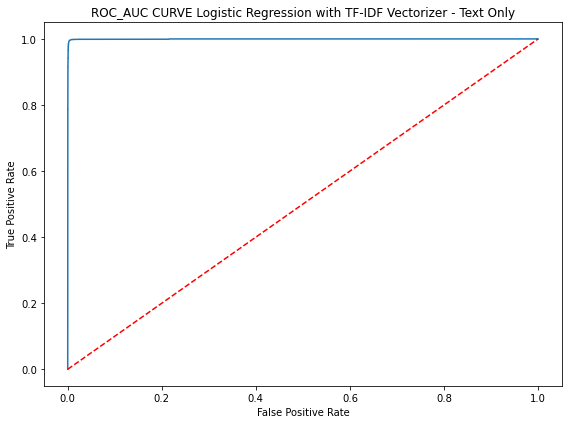

In [152]:
y_pred_proba12 = lr_tfidi.predict_proba(X_test12)[::,1]
fpr11, tpr11, _ = metrics.roc_curve(y_test12,  y_pred_proba12)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr12,tpr12)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Logistic Regression with TF-IDF Vectorizer - Text Only")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC CURVE Logistic Regression with TF-IDF Vectorizer_Text_Only.png')

# Step 7:  Look at Mis-Labeled Examples

In [153]:
lr_tfidi = LogisticRegression(C = 10)
lr_tfidi.fit(X_test12, y_test12)

LogisticRegression(C=10)

In [154]:
dict1 = {'predict_proba':lr_tfidi.predict_proba(X_test12)[:, 1], 'prediction' : lr_tfidi.predict(X_test12), 'actual' :y_test12}

In [155]:
df_preds = pd.DataFrame(dict1)

In [156]:
df_preds['sum'] = df_preds['prediction'] + df_preds['actual']
mixed = df_preds[df_preds['sum'] == 1].reset_index()


In [157]:
mixed['string'] = ''

In [158]:
for i in range(len(mixed)):
    mixed['string'].iloc[i] = df['text'].iloc[mixed['index'].iloc[i]]

In [159]:
mixed.head(4)

,index,predict_proba,prediction,actual,sum,string
0,52828,0.640240,1,0,1,with my birthday coming up i am reminiscing a ...
1,17450,0.848403,1,0,1,just a thought for suicidal people i do not kn...
2,101855,0.591574,1,0,1,the worst joke to tell to a suicidal person wh...
3,172283,0.473381,0,1,1,she does notlove me and it hurts like hell


In [160]:
false_positive = mixed[mixed['prediction'] == 1]
false_negative = mixed[mixed['prediction'] == 0]

### False Positive Cases:  Predicted Suicide but Actually Teenager

In [161]:
top_false_positive = false_positive.sort_values(by = 'predict_proba', ascending = False).head()

In [162]:
for i in range(0, 5):
    print('iteration  ' , i , ' ', top_false_positive['string'].iloc[i])
    print('')

iteration   0   i do not want to be her why

iteration   1   how to talk to someone about mental health and wellbeing from someone with mental illnesses tw depression anxiety self-harm suicide

this is my opinion and experience it differs with every person this is not the gospel what works for me might not work for others this is what i have noticed tends to work best with the most amount of people

a few weeks ago i made a post_link_to_site_ about general mental teenage health that garnered a lot of attention and support if people are interested i am gong to write more about the topic and things i think all people should know whether or not you suffer so without further ado i present

how to talk to someone with mental illness about mental health from someone with mental illnesses

the most important thing to understand first imo is that mental illness is not a choice the science is complex and super fucking interesting but the tldr is that ther are lots of chemicals governing your em

When looking at mislabeled false positives, it seems that the content of four of the five posts most predicted to be about suicide actually are about suicide.  Based on a review of these posts, it seems that most of them are about suicide or suicide prevention even though they are posted in the 'teenager' forum.

### False Negative Cases:  Predicted Teenager but Actually in the Suicide Forum

In [163]:
top_false_negative = false_negative.sort_values(by = 'predict_proba', ascending = True).head()

In [164]:
for i in range(0, 5):
    print('iteration  ' , i , ' ', top_false_negative['string'].iloc[i])
    print('')

iteration   0   advice maybedeleted

iteration   1   i am doneclick this _link_to_site_

iteration   2   ---     - --  -- -  -   --  - -  -- - - - -- -      -- -- -   --- -  - --  --   - - -  -  - -        - -  --- - - -    --- - - --- -    -- - - - --- -  -  -     -- - - - --- -  -    - - - -- --  -   -  -- ---   - -  - --- - ---  -- ---   --- - -  - --  --  - -  - - - - --  -    -   - - --  -  -- ---    --  -  - - --  -  -- ---   --   --   - - --  -  -- ---    - -  - --  - - --  -  -- ---  - - --   - - --  -  -- ---  -  --   - - --  -  -- ---   --- - -  -  - -  --   --  -   -  -    -    - -

iteration   3   -        -                             -          - 

                    -        

 -

iteration   4   over itᗰ ᔕo ᖇeᗩᗪy to eᑎᗪ it ím ѕσ ѕtrєѕѕєd σut wíth mч kídѕ thєч dσnt líѕtєn tσ mє thєч tєll mє thєч hαtє mє thєч dσnt lσvє mє thєч lσvє thєír dαd mσrє thєч wíѕh í wαѕ dєαd thє líѕt gσєѕ σn



Looking at the posts in the False Negative section.  In my mind I would classify at least one of these as potentially suicidal. however the key part of this post has misspellings / words with unexpected spelling and so it may not be interpreted properly because of how it was typed into the forum.  Four of the five do not seem to be about suicide at all as two just have dashes and  do not contain any words.  

# Step 8:  Thresholding

In [165]:
# What do we care about?  
# Definitions:  1) True Positive:  Predicted as Suicide and Actually were suicide
#               2) True Negative:  Predicted as Non-Suicide and were non-suicide
#               3)  False Positive:  Predicted as Suicide and were not suicie
#               4)  False Negative:  Predicted as non-suicide and WERE ACTUALLY SUICIDE

#    precision = tp/(tp+fp)
#    recall =  tp/(tp+fn)

# F1 = Harmonic mean of precision and recall
# Fbeta adjusts the weighting of precision and recall F2 increases importance of recall F0.5 increases weighting of precision

#  Ultimately if we are predicting who is suicidal and we predict :
#  False Positive...perhaps attention is paid to an individual who is not really suicidal
#  False Negative...someone who is really suicidal is ignored

#  THEREFORE  we care more about False Negative 
#  any Fbeta score should weigh RECALL more than precision  

In [166]:
from sklearn import tree, metrics
from sklearn.metrics import fbeta_score
d = []
for i in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1 ]:
    y_pred = (lr_tfidi.predict_proba(X_test12)[:,1] >= i).astype(bool)
    precision = metrics.precision_score(y_test12,y_pred, pos_label = 1)
    recall = metrics.recall_score(y_test12, y_pred, pos_label = 1)
    f_beta = fbeta_score(y_test12, y_pred, beta=2)
    tn_lr_tfidi, fp_lr_tfidi, fn_lr_tfidi, tp_lr_tfidi = confusion_matrix(y_test12, y_pred).ravel()
    d.append((i, precision, recall, f_beta, tp_lr_tfidi, fp_lr_tfidi, tn_lr_tfidi, fn_lr_tfidi))

In [167]:
df_threshold = pd.DataFrame(d, columns = ('Threshold', 'Precision', 'Recall', 'F-2 Score', 'True Positive', 'False Positive', 'True_Negative', 'False Negative'))


In [168]:
df_threshold['FPR'] = df_threshold['False Positive'] / (df_threshold['True_Negative'] + df_threshold['False Positive'])
df_threshold['TPR'] = df_threshold['True Positive'] / (df_threshold['True Positive'] + df_threshold['False Negative'])
df_threshold['TPR - (1-FPR)'] = df_threshold['TPR'] - (1 - df_threshold['FPR'])
df_threshold.sort_values(by = ['TPR - (1-FPR)'], ascending = True).head()

,Threshold,Precision,Recall,F-2 Score,True Positive,False Positive,True_Negative,False Negative,FPR,TPR,TPR - (1-FPR)
20,1.00,0.000000,0.000000,0.000000,0,0,29046,28967,0.000000,0.000000,-1.000000
19,0.95,0.999753,0.699313,0.744031,20257,5,29041,8710,0.000172,0.699313,-0.300515
18,0.90,0.999621,0.819933,0.850510,23751,9,29037,5216,0.000310,0.819933,-0.179757
17,0.85,0.999572,0.887424,0.907794,25706,11,29035,3261,0.000379,0.887424,-0.112198
16,0.80,0.999370,0.931059,0.943964,26970,17,29029,1997,0.000585,0.931059,-0.068355


In [169]:
x = df_threshold['Threshold']
y1 = df_threshold['Precision']

In [170]:
df_threshold.set_index('Threshold')

,Precision,Recall,F-2 Score,True Positive,False Positive,True_Negative,False Negative,FPR,TPR,TPR - (1-FPR)
Threshold,,,,,,,,,,
0.00,0.499319,1.000000,0.832955,28967,29046,0,0,1.000000,1.000000,1.000000
0.05,0.764490,0.999931,0.941914,28965,8923,20123,2,0.307202,0.999931,0.307133
0.10,0.872659,0.999068,0.970939,28940,4223,24823,27,0.145390,0.999068,0.144458
0.15,0.923185,0.999068,0.982909,28940,2408,26638,27,0.082903,0.999068,0.081971
0.20,0.951687,0.998964,0.989137,28937,1469,27577,30,0.050575,0.998964,0.049539
0.25,0.967111,0.998895,0.992372,28935,984,28062,32,0.033877,0.998895,0.032773
0.30,0.977927,0.998723,0.994493,28930,653,28393,37,0.022482,0.998723,0.021204
0.35,0.985452,0.998550,0.995903,28925,427,28619,42,0.014701,0.998550,0.013251
0.40,0.990105,0.998274,0.996629,28917,289,28757,50,0.009950,0.998274,0.008224


In [171]:
df_threshold[df_threshold['TPR - (1-FPR)'] == abs(df_threshold['TPR - (1-FPR)']).min()]

,Threshold,Precision,Recall,F-2 Score,True Positive,False Positive,True_Negative,False Negative,FPR,TPR,TPR - (1-FPR)
10,0.5,0.994693,0.996444,0.996093,28864,154,28892,103,0.005302,0.996444,0.001746


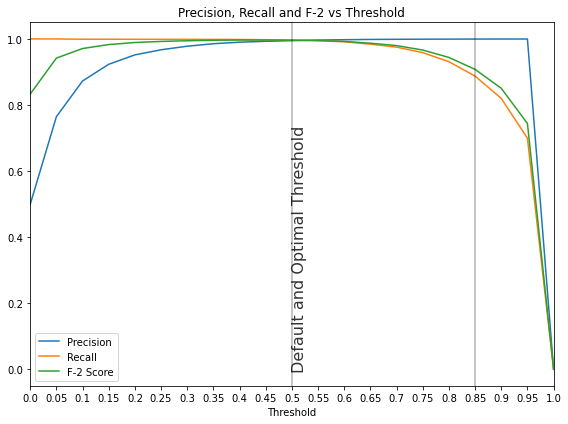

In [172]:
plt.plot(x, df_threshold['Precision'])
plt.plot(x, df_threshold['Recall'])
plt.plot(x, df_threshold['F-2 Score'])
plt.xticks(df_threshold['Threshold'], df_threshold['Threshold'].values)
plt.axvline(0.85, color='black', alpha=0.3)
plt.text(.5,.5,'',rotation=90, alpha=0.8, fontsize=16)
plt.axvline(0.5, color='black', alpha=0.3)
plt.text(.5,.0,'Default and Optimal Threshold',rotation=90, alpha=0.8, fontsize=16)
plt.xlabel('Threshold')
plt.legend(df_threshold[['Precision', 'Recall', 'F-2 Score']].columns)
plt.title('Precision, Recall and F-2 vs Threshold')
plt.xlim(0, 1)

plt.tight_layout()
plt.savefig('Thresholding: Precision, Recall and F-2 vs Threshold.png')

In the above exercise, the Default and optimal thresholds turned out to be the same.  So, lets go ahead and look at a different model to see illustrate how thresholding will help our analysis.

Thresholding exercise with model: Logistic Regression - Count Vectorizer - Text Only

In [173]:
lr = LogisticRegression(C = 1.0)
lr.fit(X_train9, y_train9)

LogisticRegression()

In [174]:
d3 = []
for i in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1 ]:
    y_pred_lr = (lr.predict_proba(X_test9)[:,1] >= i).astype(bool)
    precision_lr = metrics.precision_score(y_test9,y_pred_lr, pos_label = 1)
    recall_lr = metrics.recall_score(y_test9, y_pred_lr, pos_label = 1)
    f_beta_lr = fbeta_score(y_test9, y_pred_lr, beta=2)
    tn_lr, fp_lr, fn_lr, tp_lr = confusion_matrix(y_test9, y_pred_lr).ravel()
    d3.append((i, precision_lr, recall_lr, f_beta_lr, tp_lr, fp_lr, tn_lr, fn_lr))

In [175]:
df_threshold_lr = pd.DataFrame(d3, columns = ('Threshold', 'Precision', 'Recall', 'F-2 Score', 'True Positive', 'False Positive', 'True_Negative', 'False Negative'))


In [176]:
df_threshold_lr['FPR'] = df_threshold_lr['False Positive'] / (df_threshold_lr['True_Negative'] + df_threshold_lr['False Positive'])
df_threshold_lr['TPR'] = df_threshold_lr['True Positive'] / (df_threshold_lr['True Positive'] + df_threshold_lr['False Negative'])
df_threshold_lr['TPR - (1-FPR)'] = df_threshold_lr['TPR'] - (1 - df_threshold_lr['FPR'])
df_threshold_lr.sort_values(by = ['TPR - (1-FPR)'], ascending = True).head(21)

,Threshold,Precision,Recall,F-2 Score,True Positive,False Positive,True_Negative,False Negative,FPR,TPR,TPR - (1-FPR)
20,1.00,0.997831,0.047640,0.058848,1380,3,29043,27587,0.000103,0.047640,-0.952256
19,0.95,0.979856,0.784203,0.816823,22716,467,28579,6251,0.016078,0.784203,-0.199719
18,0.90,0.975657,0.823247,0.849797,23847,595,28451,5120,0.020485,0.823247,-0.156268
17,0.85,0.971813,0.846239,0.868689,24513,711,28335,4454,0.024478,0.846239,-0.129283
16,0.80,0.968645,0.863845,0.882951,25023,810,28236,3944,0.027887,0.863845,-0.108268
15,0.75,0.965431,0.877343,0.893651,25414,910,28136,3553,0.031330,0.877343,-0.091327
14,0.70,0.962507,0.888010,0.901973,25723,1002,28044,3244,0.034497,0.888010,-0.077493
13,0.65,0.959253,0.897228,0.908983,25990,1104,27942,2977,0.038009,0.897228,-0.064763
12,0.60,0.955730,0.905513,0.915130,26230,1215,27831,2737,0.041830,0.905513,-0.052657
11,0.55,0.952448,0.912728,0.920405,26439,1320,27726,2528,0.045445,0.912728,-0.041827


In [177]:
df_threshold_lr[df_threshold_lr['TPR - (1-FPR)'] == np.min(abs(df_threshold_lr['TPR - (1-FPR)']))]

,Threshold,Precision,Recall,F-2 Score,True Positive,False Positive,True_Negative,False Negative,FPR,TPR,TPR - (1-FPR)


In [178]:
near_zero = np.min(abs(df_threshold_lr['TPR - (1-FPR)']))
near_zero

0.0018987729428511235

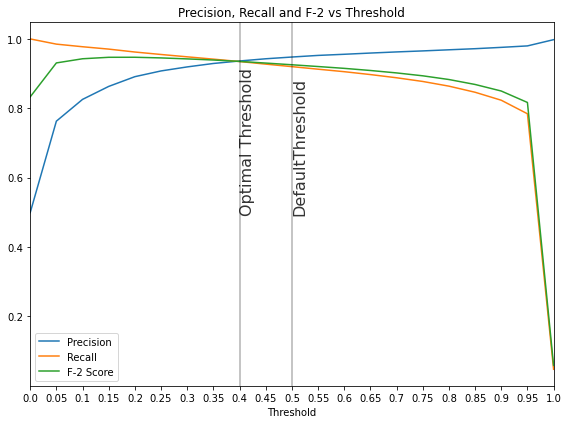

In [179]:
plt.plot(x, df_threshold_lr['Precision'])
plt.plot(x, df_threshold_lr['Recall'])
plt.plot(x, df_threshold_lr['F-2 Score'])
plt.xticks(df_threshold_lr['Threshold'], df_threshold_lr['Threshold'].values)
plt.axvline(0.4, color='black', alpha=0.3)
plt.text(.4,.5,'Optimal Threshold',rotation=90, alpha=0.8, fontsize=16)
plt.axvline(0.5, color='black', alpha=0.3)
plt.text(.5,.5,'DefaultThreshold',rotation=90, alpha=0.8, fontsize=16)
plt.xlabel('Threshold')
plt.legend(df_threshold_lr[['Precision', 'Recall', 'F-2 Score']].columns)
plt.title('Precision, Recall and F-2 vs Threshold')
plt.xlim(0, 1)
plt.rcParams.update({'figure.figsize': (8, 6.0)})

plt.tight_layout()
plt.savefig('Thresholding Second Model: Precision, Recall and F-2 vs Threshold.png')

In [180]:
df_threshold_lr[df_threshold_lr['Threshold'].isin([0.4, 0.5])]

,Threshold,Precision,Recall,F-2 Score,True Positive,False Positive,True_Negative,False Negative,FPR,TPR,TPR - (1-FPR)
8,0.4,0.936404,0.934788,0.935111,27078,1839,27207,1889,0.063313,0.934788,-0.001899
10,0.5,0.947795,0.920081,0.925494,26652,1468,27578,2315,0.050541,0.920081,-0.029378


When we set the threshold to the optimal threshold of 0.4, our precision decreases slightly but the recall and f-score increase.  We observe that the instances of false negative predictions decreases which is exactly what we would expect when setting the beta to 2.

# Step 9:  Evaluate Model with Text From a Different Source - Songs

The model predicts the source of the text very well, however it would be interesting to see how well the model predicts outside of the context of a social media posting.  Therefore, I decided to apply the model to lyrics of songs.  A quick search online identified some songs about suicide and some that were not about suicide.  The top performing model was applied to see how well the model performed with this new material from a different medium.


In [181]:
teen_spirit = 'load up on guns bring your friends it is fun to lose and to pretend she is over bored and self assured oh no i know a dirty word hello hello hello how low hello hello hello how low hello hello hello how low hello hello hello with the lights out it is less dangerous here we are now entertain us i feel stupid and contagious here we are now entertain us a mulatto an albino a mosquito my libido yeah hey yay i am worse at what i do best and for this gift i feel blessed our little group has always been and always will until the end hello hello hello how low hello hello hello how low hello hello hello how low hello hello hello with the lights out it is less dangerous here we are now entertain us i feel stupid and contagious here we are now entertain us a mulatto an albino a mosquito my libido yeah hey yay and i forget just why i taste oh yeah i guess it makes me smile i found it hard was hard to find oh well whatever never mind hello hello hello how low hello hello hello how low hello hello hello how low hello hello hello with the lights out it is less dangerous here we are now entertain us i feel stupid and contagious here we are now entertain us a mulatto an albino a mosquito my libido a denial a denial a denial a denial a denial a denial a denial a denial a denial'
save_myself ='i gave all my oxygen to people that could breathe i gave away my money and now we do not even speak i drove miles and miles but would you do the same for me oh honestly offered off my shoulder just for you to cry upon gave you constant shelter and a bed to keep you warm they gave me the heartache and in return i gave a song it goes on and on life can get you down so i just numb the way it feelsi drown it with a drink and out of date prescription pills and all the ones that love me they just left me on the shelf my farewell so before i save someone else i have got to save myself i gave you all my energy and i took away your pain because human beings are destined to radiate or dream what line do we stand upon because from here looks the same and only scars remain life can get you down so i just numb the way it feels i drown it with a drink and out of date prescription pills and all the ones that love me they just left me on the shelf my farewell so before i save someone else i have got to save myself but if do not then i will go back to where i am rescuing a stranger just because they needed saving just like that oh i am here again between the devil and the danger but i guess it is just my nature my dad was wrong because i am not like my mum because she would just smile and i am complaining in a song but it helps so before i save someone else i have got to save myself life can get you down so i just numb the way it feels i drown it with a drink and out of date prescription pills and all the ones that love me they just left me on the shelf my farewell so before i save someone else  i have got to save myself '
everybody_hurts ='when your day is long and the night the night is yours alone when you are sure you have had enough of this life well hang on do not let yourself go because everybody cries everybody hurts sometimes ometimes everything is wrong now its time to sing along when your day is night alone hold on hold on if you feel like letting go hold on if you think you have had too much of this life well hang on because everybody hurts take comfort in your friends everybody hurts do not throw your hand oh no do not throw your hand if you feel like you are alone no no no you are not alone if you are on your own in this life the days and nights are long when you think you have had too much of this life to hang on well everybody hurts sometimes everybody cries everybody hurts sometimes and everybody hurts sometimes so hold on hold on hold on hold on hold on hold on hold on hold on everybody hurts'
happy_know_it = 'if you are happy and you know it clap your hands if you are happy and you know it then your face will surely show it if you are happy and you know if clap your hands'
wonderful_world = 'i see trees of green red roses too i see them bloom for me and you and i think to myself what a wonderful world i see skies of blue and clouds of white the bright blessed day the dark sacred night and i think to myself what a wonderful world the colors of the rainbow so pretty in the sky are also on the faces of people going by i see friends shaking hands saying how do you do they are really saying i love you i hear babies crying i watch them grow they willl learn much more than i will ever know and i think to myself what a wonderful world yes i think to myself what a wonderful world ooh yes'
r_roll = 'we are no strangers to love you know the rules and so do i a full commitment is what i am thinking of you would not get this from any other guy i just wanna tell you how i am feeling gotta make you understand never gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you we have known each other for so long your heart has been aching but you are too shy to say it inside we both know what has been going on we know the game and we are gonna play it and if you ask me how i am feeling do not tell me you are too blind to see never gonna give you up never gonna let you down  never gonna run around and desert you never gonna make you cry never gonna say goodbye  never gonna tell a lie and hurt you never gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you we have known each other for so long your heart has been aching but you are too shy to say it inside we both know what has been going on we know the game and we are gonna play it i just wanna tell you how i am feeling gotta make you understand never gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you '
adams_song = 'i never thought i would die alone i laughed the loudest who wouldd have known i trace the cord back to the wall no wonder it was never plugged in at all i took my time i hurried up the choice was mine i did not think enough i am too depressed to go on you will be sorry when i am gone i never conquered rarely came sixteen just held such better days days when i still felt alive we could not wait to get outside the world was wide too late to try the tour was over we had survived i could not wait until i got home to pass the time in my room alone i never thought i would die alone another six months i will be unknown give all my things to all my friends you will never step foot in my room again you will close it off board it up remember the time that i spilled the cup of apple juice in the hall please tell mom this is not her fault i never conquered rarely came sixteen just held such better days days when i still felt alive we could not wait to get outside the world was wide too late to try the tour was over we had survived i could not wait till i got home to pass the time in my room alone i never conquered rarely came tomorrow holds such better days days when i can still feel alive when i ca not wait to get outside the world is wide the time goes by the tour is over i have survived i can not wait until i get home to pass the time in my room alone'
cemetary_drive = 'this night walk the dead in a solitary style and crash the cemetery gates in the dress your husband hates way down mark the grave where the search lights find us drinking by the mausoleum door and they found you on the bathroom floor i miss you i miss you so far and the collision of your kiss that made it so hard back home off the run singing songs that make you slit your wrists it is not that much fun staring down a loaded gun so, i will not stop dying will not stop lying if you want i will keep on crying did you get what you deserve is this what you always want me for i miss you i miss you so far and the collision of your kiss that made it so hard way down way down way down, way down i miss you i miss you so far and the collision of your kiss that made it so hard when will i miss you when will i miss you so far and the collision of your kiss that made it so hard made it so hard way down way down '
walking_sunshine = 'oh ohhhh yeeeh i used to think maybe you loved me now baby i am sure  and i just cannot wait until the day when you knock on my door now everytime i go for the mailbox gotta hold myself down because i just cannot wait until you write me you are coming around i am walking on sunshine wooah i am walking on sunshine woooah i am walking on sunshine woooah and does it not feel good  hey alright now and dont it feel good hey yeah i used to think maybe you loved me now i know that it is true and i do not want to spend my whole life just waiting for you now i do not want you back for the weekend not back for a day no no no i said baby i just want you back and i want you to stay woah yeah i am walking on sunshine wooah i am walking on sunshine woooah i am walking on sunshine woooah and does it not feel good hey alright now and does it not feel good yeah oh yeah and does it feel good walking on sunshine walking on sunshine i feel alive i feel the love i feel the love that is really real i feel alive i feel the love i feel the love that is really real i am on sunshine baby oh oh yeah i am on sunshine baby oh i am walking on sunshine wooah i am walking on sunshine wooah i am walking on sunshine woooah and does it not feel good hey alright now and does it feel good i will say it say it say it again now and dooes it feel good ohhhh yeahhhh and does it feel good now does it does it does it does it does it does it feel good i will say it say it say it again now and does it feel good now does it does it does it does it does it does it feel good tell me tell me tell me again now and does it feel good oh yeah and does it feel good oh does it feel good does it feel good '
haunted = 'louder louder the voices in my head whispers taunting all the things you said faster the days go by and i am still stuck in this moment of wanting you here time in the blink of an eye you held my hand you held me tight now you are gone and i am still crying shocked broken i am dying inside where are you i need you do not leave me here on my own speak to me be near me i can not survive unless i know you are with me shadows linger only to my eye i see you i feel you do not leave my side it is not fair just when i found my world they took you they broke you they tore out your heart i miss you you hurt me you left with a smile mistaken your sadness was hiding inside now all that is left are the pieces to find the mystery you kept the soul behind a guise where are you i need you do not leave me here on my own speak to me be near me i can not survive unless i know you are with me why did you go all these questions run through my mind i wish i could not feel at all let me be numb i am starting to fall where are you i need you do not leave me here on my own speak to me be near me i can not survive unless i know you are with me where are you where are you you were smiling'

In [182]:
dict1 = {'title':['Smells Like Teen Spirit', 'Walking on Sunshine', 'Everybody Hurts', 'Happy and You Know It', 'Wonderful World', 'Never Gonna Give You Up', 'Save Myself', 'Adams Song', 'Cemetary Drive', 'Haunted'],
        'song':[teen_spirit, walking_sunshine, everybody_hurts, happy_know_it, wonderful_world, r_roll, save_myself, adams_song, cemetary_drive, haunted],
        'length':[len(teen_spirit), len(walking_sunshine), len(everybody_hurts), len(happy_know_it), len(wonderful_world), len(r_roll), len(save_myself), len(adams_song), len(cemetary_drive), len(haunted)], 
         'class': [0, 0, 1 ,0, 0, 0, 1, 1, 1, 1]
       }

In [183]:
df_song = pd.DataFrame(dict1)

In [184]:
df_song.head()

,title,song,length,class
0,Smells Like Teen Spirit,load up on guns bring your friends it is fun t...,1280,0
1,Walking on Sunshine,oh ohhhh yeeeh i used to think maybe you loved...,1679,0
2,Everybody Hurts,when your day is long and the night the night ...,886,1
3,Happy and You Know It,if you are happy and you know it clap your han...,165,0
4,Wonderful World,i see trees of green red roses too i see them ...,598,0


In [185]:
df_song['repetition'] = ''

In [186]:
df_song.head()

,title,song,length,class,repetition
0,Smells Like Teen Spirit,load up on guns bring your friends it is fun t...,1280,0,
1,Walking on Sunshine,oh ohhhh yeeeh i used to think maybe you loved...,1679,0,
2,Everybody Hurts,when your day is long and the night the night ...,886,1,
3,Happy and You Know It,if you are happy and you know it clap your han...,165,0,
4,Wonderful World,i see trees of green red roses too i see them ...,598,0,


In [187]:
for j in range(len(df_song)):
    words = df_song['song'].iloc[j].split(" ")  
    count = 0; 
    for i in range(len(words)-1):  
        if words[i] == words[i+1]:
            count = count + 1

        df_song['repetition'].iloc[j] = count

In [188]:
df_song.head()

,title,song,length,class,repetition
0,Smells Like Teen Spirit,load up on guns bring your friends it is fun t...,1280,0,24
1,Walking on Sunshine,oh ohhhh yeeeh i used to think maybe you loved...,1679,0,3
2,Everybody Hurts,when your day is long and the night the night ...,886,1,2
3,Happy and You Know It,if you are happy and you know it clap your han...,165,0,0
4,Wonderful World,i see trees of green red roses too i see them ...,598,0,0


In [189]:
df_song['sentiment'] = ''
df_song['length'] = ''
df_song['flesch_kincaid'] = ''

In [190]:
from textblob import TextBlob
import textstat
for i in range(len(df_song)):
    df_song['length'].iloc[i] = len(df_song['song'].iloc[i])
    df_song['sentiment'].iloc[i] = TextBlob(df_song['song'].iloc[i]).polarity
    df_song['flesch_kincaid'].iloc[i] = textstat.flesch_kincaid_grade(df_song['song'].iloc[i])

In [191]:
df_song

,title,song,length,class,repetition,sentiment,flesch_kincaid
0,Smells Like Teen Spirit,load up on guns bring your friends it is fun t...,1280,0,24,-0.19892,102.7
1,Walking on Sunshine,oh ohhhh yeeeh i used to think maybe you loved...,1679,0,3,0.48771,141.7
2,Everybody Hurts,when your day is long and the night the night ...,886,1,2,0.1125,67.6
3,Happy and You Know It,if you are happy and you know it clap your han...,165,0,0,0.725,11.8
4,Wonderful World,i see trees of green red roses too i see them ...,598,0,0,0.373333,47.3
5,Never Gonna Give You Up,we are no strangers to love you know the rules...,1741,0,0,-0.158796,139.4
6,Save Myself,i gave all my oxygen to people that could brea...,1632,1,0,0.010606,135.5
7,Adams Song,i never thought i would die alone i laughed th...,1364,1,3,0.076,110.5
8,Cemetary Drive,this night walk the dead in a solitary style a...,911,1,0,-0.114418,73.8
9,Haunted,louder louder the voices in my head whispers t...,1181,1,3,-0.02381,100.7


In [192]:
df2 = df_song[['sentiment', 'flesch_kincaid', 'repetition', 'length']]

In [193]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
scaler = MinMaxScaler()
scaler.fit(df2)
df_scaled = scaler.transform(df2)
scaled_features_df = pd.DataFrame(df_scaled, index=df2.index, columns=df2.columns)

In [194]:
text_matrix = vectorizor_tfid.transform(df_song['song'])
text_matrix = text_matrix.tocsc() 
length = scaled_features_df['length'].values[:, None]
sentiment = scaled_features_df['sentiment'].values[:, None]
reading_level = scaled_features_df['flesch_kincaid'][:, None]
repetition = scaled_features_df['repetition'][:, None]
first = hstack((text_matrix, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X_song = hstack((third, sentiment))

y_song = df_song['class']

In [195]:
lr_tfidi.predict(X_song)

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 1])

In [196]:
song_pred = lr_tfidi.predict(X_song)

In [197]:
accuracy_song = metrics.accuracy_score(y_song,song_pred)
balanced_accuracy_song = metrics.balanced_accuracy_score(y_song,song_pred)
precision_song = metrics.precision_score(y_song,song_pred, pos_label = 1)
recall_song = metrics.recall_score(y_song,song_pred, pos_label = 1)
f1_song = metrics.f1_score(y_song,song_pred, pos_label = 1)
roc_auc_song = metrics.roc_auc_score(y_song,song_pred)
print("Accuracy:", accuracy_song)
print("Balanced accuracy:", balanced_accuracy_song)
print('Precision score' , precision_song)
print('Recall score' , recall_song)
print('F1 score' , f1_song)
print('ROC_AUC Score' , roc_auc_song)

Accuracy: 1.0
Balanced accuracy: 1.0
Precision score 1.0
Recall score 1.0
F1 score 1.0
ROC_AUC Score 1.0


In [198]:
pd.DataFrame(confusion_matrix(y_song, song_pred), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,5,0
Actual Suicide,0,5


# Step 10:  Summary

The goal of this project was to build a model that would use natural language processing to determine whether social media postings were from a suicide forum or from a teenager forum.  The idea was to develop a tool that would be able to detect suicidal tendencies in the person posting on social media.  In the end, the tuned model was able to predict the source of posted text very well.  The ROC-AUC score of our final model was 0.995.  

This seems accurate enough to be useful although further conversations with potential stakeholders could shed light on their needs for improved accuracy.

Such stakeholders may include:

* Schools or parents who wish to monitor children's social media activities.

* Social media companies who may want to monitor social media postings for suicial tendencies in order to appear socially responsible.

*  Firearms manufacturers or mental health councillors who may want to target their advertisements to suicical customers.

#  Step 11:  Next Steps

The model did a very good job of predicting the source of the text.  However, the language used in the teenager forum was markedly different from the language used in the suicide forum.  The differences in the group were fairly obvious.  It may be beneficial to conduct a similar analysis between to more similar groups ie depressed group and suicidal group in order to see how well this model or another model performs in the case of more subtle differences in the language between groups.  

In addition, while a few features were engineered such as length of the posting, grade level, sentiment, and repetition, in the end the inclusion of these engineered features did not improve the performance of the model.  Conversations with potential stakeholders or experts in the field may yield additional feature engineering that could be performed to improve the performance of the model. 

Finally, a significant amount of time was spent optimizing the hyperparameters and each of our models included either one or two hyperparameters to tune. However, it is likely that including additional parameters in a future analysis could result in a more robust model.